# Data Description:

## colorado:
* year, district/state/school, grade, exam wise mean_scale_score
* year: 2017-2021 (No 2020)

## Connecticut: 
* year, district, school, grade, exam, average vss
* year: 2017-2021 (No 2020)
* within 1 district there are several schools. So no 1-1 district to school mapping
* might take school as an aggregator and not district
* can be aggregated on district level somehow, but need to see the method

## Florida:
* year, district, grade, exam, mean scale score
* year: 2017-2021 (No 2020)
* major issue is that data is consolidated on distric level and not school level

## Massachusetts:
* year, district, subject
* grade is missing that is major factor
* year: 2017-2021 (No 2020)

## Newyork:
* year, school, grade, exam, subgroup (ethnicity), mean_scale_score
* Need to get rid of ethnicity and aggregate over school.
* Further pre-processing needed: extract year from date column, extract grade from item_desc

## Next Steps:
* Florida has missing school level info and Massachusetts miss grade level info. So might drop them for the analysis
* Newyourk needs to processing and aggregation on school level and remove ethinicty (might take just average)
* Normalize the score of each state
* Final analysis would have only Newyork, Connecticut and colorado
* Compare all three states have consistent dataframes
* Join all three states data

In [161]:
## loading all the relevant libraries

import pandas as pd
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
import difflib 
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from datetime import datetime
from fuzzymatcher import link_table, fuzzy_left_join
from sklearn.model_selection import cross_val_score,KFold
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from scipy.stats import gaussian_kde

In [2]:
### Define all funcitons in this code ###

def load_data_preprocess(main_path, name):
    """
    This function loads multiple csv files, and stores them as part of 
    dictionary. Their related column names is also stored in a dictionary
    
    """
    data_dict = {}
    col_name = {}
    for i in name:
        df_load = pd.read_csv(main_path+'/'+i+'.csv',header = 0)
        df_col = df_load.columns 
        #data_dict[i].append(list(df_load))
        data_dict.update({i: np.array(df_load)})
        col_name.update({i: np.array(df_col)})
       
    final_dict = {'data':data_dict,'col_names':col_name}
    return final_dict

make_df = lambda df, col_names: pd.DataFrame(df, columns = col_names) ## make dataframe from a csv file

remove_duplicates = lambda df: df.drop_duplicates(keep = 'last',inplace=False, ignore_index=False) 

def check_unique(df):
    """
    Checks unique values for each column in dataframe
    
    """
    for col in df:
        print(df[col].value_counts().sort_values(ascending = False))
        
def check_na(df):
    for col in df:
        print(col)
        print(df[col].isnull().sum())
        print('\n')
        
min_max = lambda df,col,city: print(city + '\n' +'min: '+str(df[col].min()) + '\n' + 'max: '+str(df[col].max())) ## checks min max value for each column

min_max_norm = lambda df,col: (df[col]-df[col].min())/(df[col].max()-df[col].min()) ## apply min max normalization for a given column of dataframe

def convert_to_string(df,cols):
    """
    converts columns into string and makes them lower case
    
    """
    for i in range(len(cols)):
        df[cols[i]] = df[cols[i]].astype('str').str.lower()
        
        
def fuzzy_merge(df_1, df_2, key1, key2, threshold=90, limit=2):
    """
    :param df_1: the left table to join
    :param df_2: the right table to join
    :param key1: key column of the left table
    :param key2: key column of the right table
    :param threshold: how close the matches should be to return a match, based on Levenshtein distance
    :param limit: the amount of matches that will get returned, these are sorted high to low
    :return: dataframe with boths keys and matches
    """
    s = df_2[key2].tolist()
    
    m = df_1[key1].apply(lambda x: process.extract(x, s, limit=limit))    
    df_1['matches'] = m
    
    m2 = df_1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    df_1['matches'] = m2
    
    return df_1


def check_unique(df):
    """
    Checks unqiue values of data frame like unique values, NA values and table info
    
    """
    for col in df:
        print(col)
        print(df[col].unique())
        print('\n')


def data_check(df):
    """
    Checks various statistics of data frame like unique values, NA values and table info
    
    """
    print("Unique Values")
    for col in df:
        print(df[col].unique)
    
    print("\n")
    print("NA Values")
    for col in df:
        print("couunt of NA values in", col)
        print(df[col].isnull().sum())
    
    print("\n")
    print("Table info")
    df.info()

def format_employment(path_df):
    """
    loads and format employment data 
    
    """
    
    df = pd.read_excel(path+path_df, header = 0)
    rel_cols = ['FIPS ','Name','2013',2014,2015,2016,2017,2018,2019,2020,'2021']
    df = df[rel_cols]
    df.columns = ['FIPS','Name','2013','2014','2015','2016','2017','2018','2019','2020','2021']
    return df

In [3]:
### extract all the data frames with their relevant column names ###

path = 'C:/Users/ameen/Desktop/Covid_learning_gap_ML_project_17_oct/datasets_processed'
state_names = ['colorado','connecticut','florida','massachusetts','ny']

data_dict = load_data_preprocess(path,state_names)

data, col_names = itemgetter('data','col_names')(data_dict)
data_col,data_con,data_flor,data_mass,data_ny = itemgetter('colorado','connecticut','florida','massachusetts','ny')(data)

data_col= make_df(data_col,col_names['colorado']) 
data_con = make_df(data_con,col_names['connecticut'])
data_flor = make_df(data_flor,col_names['florida'])
data_mass = make_df(data_mass,col_names['massachusetts'])
data_ny = make_df(data_ny,col_names['ny'])

In [4]:
print(data_col.head())
print('*****************')
print('*****************')
print('*****************')
print(data_col['Level'].value_counts())
print('*****************')
print('*****************')
print('*****************')
data_col[data_col['Level']=='SCHOOL']['School_Name'].value_counts()
print('*****************')
print('*****************')
print('*****************')
data_col['year'].value_counts()

  Unnamed: 0  year   Level District_Code District_Name  \
0       2783  2017  SCHOOL          1040    ACADEMY 20   
1       2784  2017  SCHOOL          1040    ACADEMY 20   
2       2785  2017  SCHOOL          1040    ACADEMY 20   
3       2786  2017  SCHOOL          1040    ACADEMY 20   
4       2787  2017  SCHOOL          1040    ACADEMY 20   

                               School_Name  Content Grade Mean_Scale_Score  
0      ACADEMY ENDEAVOUR ELEMENTARY SCHOOL  english     3              752  
1  ACADEMY INTERNATIONAL ELEMENTARY SCHOOL  english     3              754  
2        ANTELOPE TRAILS ELEMENTARY SCHOOL  english     3              749  
3          CHINOOK TRAIL ELEMENTARY SCHOOL  english     3              774  
4            THE CLASSICAL ACADEMY CHARTER  english     3              756  
*****************
*****************
*****************
SCHOOL    31421
Name: Level, dtype: int64
*****************
*****************
*****************
*****************
*****************
***

2017    9171
2019    9009
2018    8973
2021    4268
Name: year, dtype: int64

In [5]:
print(data_con.head())
print('*****************')
print('*****************')
print('*****************')
print(data_con['year'].value_counts())
print('*****************')
print('*****************')
print('*****************')
data_con[(data_con['year']==2017) & (data_con['Grade']==3) & (data_con['Subject']=='ELA')].groupby(['District'])['School'].count().sort_values(ascending = False)
print('*****************')
print('*****************')
print('*****************')
print(data_con[(data_con['District']=='New Haven School District') & (data_con['year']==2017)& (data_con['Grade']==3) & (data_con['Subject']=='ELA')])


  Unnamed: 0  year                                       District  \
0          0  2017  Achievement First Bridgeport Academy District   
1          1  2017  Achievement First Bridgeport Academy District   
2          2  2017  Achievement First Bridgeport Academy District   
3          3  2017  Achievement First Bridgeport Academy District   
4          4  2017  Achievement First Bridgeport Academy District   

  District Code                                School School Code Grade  \
0       2850013  Achievement First Bridgeport Academy     2850113     3   
1       2850013  Achievement First Bridgeport Academy     2850113     3   
2       2850013  Achievement First Bridgeport Academy     2850113     4   
3       2850013  Achievement First Bridgeport Academy     2850113     4   
4       2850013  Achievement First Bridgeport Academy     2850113     5   

  Subject Average VSS  
0     ELA        2495  
1    Math        2514  
2     ELA        2520  
3    Math        2535  
4     ELA     

In [6]:
print(data_flor.head())
print('*****************')
print('*****************')
print('*****************')
print(data_flor['year'].value_counts())

  Unnamed: 0  year District Number District Name Grade Mean Scale Score   \
0          0  2017               1       ALACHUA     3               302   
1          1  2017               2         BAKER     3               307   
2          2  2017               3           BAY     3               299   
3          3  2017               4      BRADFORD     3               297   
4          4  2017               5       BREVARD     3               302   

  subject  
0   Maths  
1   Maths  
2   Maths  
3   Maths  
4   Maths  
*****************
*****************
*****************
2017    735
2018    735
2019    735
2021    732
Name: year, dtype: int64


In [7]:
print(data_mass.shape)
print('*****************')
print('*****************')
print('*****************')
print(data_mass.head)
print(data_mass['year'].value_counts())

(3568, 6)
*****************
*****************
*****************
<bound method NDFrame.head of      Unnamed: 0  year                                      District Name  \
0             0  2017       Abby Kelley Foster Charter Public (District)   
1             1  2017       Abby Kelley Foster Charter Public (District)   
2             2  2017                                           Abington   
3             3  2017                                           Abington   
4             4  2017  Academy Of the Pacific Rim Charter Public (Dis...   
...         ...   ...                                                ...   
3563       1057  2021                                           Wrentham   
3564       1058  2021                                           Wrentham   
3565       1059  2021                                              State   
3566       1060  2021                                              State   
3567       1061  2021                                              Sta

In [8]:
print(data_ny.shape)
data_ny.head()

(1374876, 8)


,Unnamed: 0,SY_END_DATE,NAME,ITEM_SUBJECT_AREA,ITEM_DESC,SUBGROUP_CODE,SUBGROUP_NAME,MEAN_SCALE_SCORE
0,2,06/30/2017,KIPP ACADEMY CHARTER SCHOOL,ELA,Grade 7 ELA,15,Economically Disadvantaged,321
1,3,06/30/2017,KIPP ACADEMY CHARTER SCHOOL,ELA,Grade 7 ELA,16,Not Economically Disadvantaged,332
2,4,06/30/2017,KIPP ACADEMY CHARTER SCHOOL,ELA,Grade 7 ELA,18,Not Migrant,323
3,5,06/30/2017,KIPP ACADEMY CHARTER SCHOOL,Mathematics,Grade 7 Math,1,All Students,323
4,6,06/30/2017,KIPP ACADEMY CHARTER SCHOOL,Mathematics,Grade 7 Math,2,Female,321


In [9]:
#data_ny.query("NAME == 'KIPP ACADEMY CHARTER SCHOOL' & ITEM_SUBJECT_AREA == 'ELA' & ITEM_DESC == 'Grade 7 ELA'")[['SY_END_DATE','ITEM_DESC','SUBGROUP_NAME','MEAN_SCALE_SCORE']]
data_ny_fil = data_ny.query("SUBGROUP_NAME == 'All Students'")
data_ny_fil['SY_END_DATE'] = pd.to_datetime(data_ny_fil['SY_END_DATE'])
data_ny_fil['year'] = pd.DatetimeIndex(data_ny_fil['SY_END_DATE']).year
print(data_ny.shape)
print(data_ny_fil.shape)

(1374876, 8)
(125200, 9)


C:\Users\ameen\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '30/06/2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\ameen\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '30/06/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\ameen\AppData\Local\Temp\ipykernel_28344\3978369808.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ny_fil['SY_END_DATE'] = pd.to_datetime(data_ny_fil['SY_END_DATE'])
C:\Users\am

In [10]:
print(data_ny_fil.columns)
print(data_con.columns)
print(data_col.columns)

Index(['Unnamed: 0', 'SY_END_DATE', 'NAME', 'ITEM_SUBJECT_AREA', 'ITEM_DESC',
       'SUBGROUP_CODE', 'SUBGROUP_NAME', 'MEAN_SCALE_SCORE', 'year'],
      dtype='object')
Index(['Unnamed: 0', 'year', 'District', 'District Code', 'School',
       'School Code', 'Grade', 'Subject', 'Average VSS'],
      dtype='object')
Index(['Unnamed: 0', 'year', 'Level', 'District_Code', 'District_Name',
       'School_Name', 'Content', 'Grade', 'Mean_Scale_Score'],
      dtype='object')


## Final Table Columns:

* year: integar column
* school: text column
* grade: integer (3-8)
* exam: 'English' or 'Math'
* state: colorado, connecticut, newyork
* score: float (standardize all 3 before joining)

## Making all Three Tables Consistent:

## Newyork:

In [11]:
data_ny_fil.head()

,Unnamed: 0,SY_END_DATE,NAME,ITEM_SUBJECT_AREA,ITEM_DESC,SUBGROUP_CODE,SUBGROUP_NAME,MEAN_SCALE_SCORE,year
3,5,2017-06-30,KIPP ACADEMY CHARTER SCHOOL,Mathematics,Grade 7 Math,1,All Students,323,2017
12,18,2017-06-30,KIPP ACADEMY CHARTER SCHOOL,ELA,Grade 8 ELA,1,All Students,313,2017
19,31,2017-06-30,KIPP ACADEMY CHARTER SCHOOL,Mathematics,Grade 8 Math,1,All Students,313,2017
26,44,2017-06-30,BRONX CHARTER SCHOOL FOR CHILDREN (THE),ELA,Grade 3 ELA,1,All Students,324,2017
38,56,2017-06-30,BRONX CHARTER SCHOOL FOR CHILDREN (THE),Mathematics,Grade 3 Math,1,All Students,320,2017


In [12]:
col_names_final = ['year','school','grade','exam','score'] ## final columns that will be present in the table
data_ny_fin = data_ny_fil[['year','NAME','ITEM_DESC','ITEM_SUBJECT_AREA','MEAN_SCALE_SCORE']]  
data_ny_fin.columns = col_names_final
data_ny_fin['school'] = data_ny_fin['school'].str.lower()
data_ny_fin['grade'] = data_ny_fin['grade'].apply(lambda x: int(str(x).split(" ")[1])) ## grade column in ny dataframe is formatted using split command
data_ny_fin['exam'] = data_ny_fin['exam'].apply(lambda x:'maths' if (x == 'Mathematics') else ('english')) ## making exam column consistent
data_ny_fin['score'] = data_ny_fin['score'].astype('int') ## converting score column to integer

print('shape of newyork old dataframe')
print(data_ny_fin.shape)

##removing duplicates
data_ny_fin = remove_duplicates(data_ny_fin)

data_ny_fin['state'] = 'newyork'

print('shape of newyork final dataframe')
print(data_ny_fin.shape)
data_ny_fin.head()

C:\Users\ameen\AppData\Local\Temp\ipykernel_28344\4154843559.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ny_fin['school'] = data_ny_fin['school'].str.lower()
C:\Users\ameen\AppData\Local\Temp\ipykernel_28344\4154843559.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ny_fin['grade'] = data_ny_fin['grade'].apply(lambda x: int(str(x).split(" ")[1])) ## grade column in ny dataframe is formatted using split command


shape of newyork old dataframe
(125200, 5)
shape of newyork final dataframe
(125164, 6)


C:\Users\ameen\AppData\Local\Temp\ipykernel_28344\4154843559.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ny_fin['exam'] = data_ny_fin['exam'].apply(lambda x:'maths' if (x == 'Mathematics') else ('english')) ## making exam column consistent
C:\Users\ameen\AppData\Local\Temp\ipykernel_28344\4154843559.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ny_fin['score'] = data_ny_fin['score'].astype('int') ## converting score column to integer


,year,school,grade,exam,score,state
3,2017,kipp academy charter school,7,maths,323,newyork
12,2017,kipp academy charter school,8,english,313,newyork
19,2017,kipp academy charter school,8,maths,313,newyork
26,2017,bronx charter school for children (the),3,english,324,newyork
38,2017,bronx charter school for children (the),3,maths,320,newyork


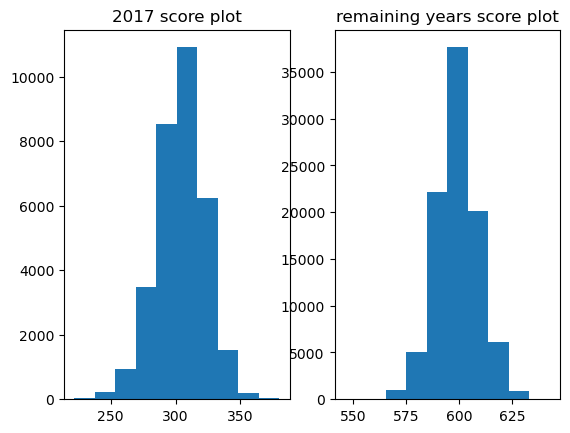

In [13]:
## the scaling score for 2017 and rest of the years were different
## seperate scaling will be done
## refer to below histograms to understand better

fig, axs = plt.subplots(ncols=2)
axs[0].hist(data_ny_fin.query('year == 2017')['score'])
axs[0].set_title('2017 score plot')
axs[1].hist(data_ny_fin.query('year != 2017')['score'])
axs[1].set_title('remaining years score plot')
plt.show()

#data_ny_fin.groupby(['year','grade','exam'])['score'].agg(('mean','count'))

## Connecticut

* Same data processing will be done for Connecticut as done above for NY

In [14]:
data_con.head()

,Unnamed: 0,year,District,District Code,School,School Code,Grade,Subject,Average VSS
0,0,2017,Achievement First Bridgeport Academy District,2850013,Achievement First Bridgeport Academy,2850113,3,ELA,2495
1,1,2017,Achievement First Bridgeport Academy District,2850013,Achievement First Bridgeport Academy,2850113,3,Math,2514
2,2,2017,Achievement First Bridgeport Academy District,2850013,Achievement First Bridgeport Academy,2850113,4,ELA,2520
3,3,2017,Achievement First Bridgeport Academy District,2850013,Achievement First Bridgeport Academy,2850113,4,Math,2535
4,4,2017,Achievement First Bridgeport Academy District,2850013,Achievement First Bridgeport Academy,2850113,5,ELA,2470


In [15]:
#col_names_final = ['year','school','grade','exam','score']

data_con_fin = data_con[['year','School','Grade','Subject','Average VSS']] 
data_con_fin.columns = col_names_final
data_con_fin['year'] = data_con_fin['year'].astype('int')
data_con_fin['grade'] = data_con_fin['grade'].astype('int')
data_con_fin['score'] = data_con_fin['score'].astype('int')
data_con_fin['school'] = data_con_fin['school'].astype('str').str.lower()
data_con_fin['exam'] = data_con_fin['exam'].apply(lambda x:'maths' if (x == 'Math') else ('english'))

print('shape of conneticut old dataframe')
print(data_ny_fin.shape)

##removing duplicates
data_con_fin = remove_duplicates(data_con_fin)

data_con_fin['state'] = 'connecticut'

print('shape of connecticut final dataframe')
print(data_ny_fin.shape)
data_ny_fin.head()


shape of conneticut old dataframe
(125164, 6)
shape of connecticut final dataframe
(125164, 6)


C:\Users\ameen\AppData\Local\Temp\ipykernel_28344\409064201.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_con_fin['year'] = data_con_fin['year'].astype('int')
C:\Users\ameen\AppData\Local\Temp\ipykernel_28344\409064201.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_con_fin['grade'] = data_con_fin['grade'].astype('int')
C:\Users\ameen\AppData\Local\Temp\ipykernel_28344\409064201.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

,year,school,grade,exam,score,state
3,2017,kipp academy charter school,7,maths,323,newyork
12,2017,kipp academy charter school,8,english,313,newyork
19,2017,kipp academy charter school,8,maths,313,newyork
26,2017,bronx charter school for children (the),3,english,324,newyork
38,2017,bronx charter school for children (the),3,maths,320,newyork


## Colorado:

* Same data processing will be done for Colorado as done above for NY

In [16]:
data_col.head()

,Unnamed: 0,year,Level,District_Code,District_Name,School_Name,Content,Grade,Mean_Scale_Score
0,2783,2017,SCHOOL,1040,ACADEMY 20,ACADEMY ENDEAVOUR ELEMENTARY SCHOOL,english,3,752
1,2784,2017,SCHOOL,1040,ACADEMY 20,ACADEMY INTERNATIONAL ELEMENTARY SCHOOL,english,3,754
2,2785,2017,SCHOOL,1040,ACADEMY 20,ANTELOPE TRAILS ELEMENTARY SCHOOL,english,3,749
3,2786,2017,SCHOOL,1040,ACADEMY 20,CHINOOK TRAIL ELEMENTARY SCHOOL,english,3,774
4,2787,2017,SCHOOL,1040,ACADEMY 20,THE CLASSICAL ACADEMY CHARTER,english,3,756


In [17]:
data_col.groupby(['Content','Grade'])['year'].value_counts()

## filter ela, english language arts, math, mathematics --> different naming conventions for different years


Content  Grade  year
english  3      2019    986
                2018    977
                2017    967
                2021    922
         4      2018    980
                2019    980
                2017    964
         5      2019    997
                2018    974
                2017    965
                2021    929
         6      2018    600
                2017    587
                2019    555
         7      2019    502
                2018    488
                2021    481
                2017    472
         8      2019    484
                2018    475
                2017    470
         9      2017    346
maths    3      2019    987
                2018    979
                2017    969
         4      2019    981
                2018    980
                2017    964
                2021    938
         5      2019    997
                2018    974
                2017    966
         6      2018    598
                2017    587
                2019    555

In [18]:
#col_names_final = ['year','school','grade','exam','score']

data_col_fin = data_col[['year','School_Name','Grade','Content','Mean_Scale_Score']]
data_col_fin.columns = col_names_final
data_col_fin['year'] = data_col_fin['year'].astype('int')
data_col_fin['grade'] = data_col_fin['grade'].astype('int')
data_col_fin['score'] = data_col_fin['score'].astype('int')
data_col_fin['school'] = data_col_fin['school'].astype('str').str.lower()

print('shape of colorado old dataframe')
print(data_col_fin.shape)

##removing duplicates
data_col_fin = remove_duplicates(data_col_fin)
data_col_fin['state'] = 'colorado' 

print('shape of colorado final dataframe')
print(data_col_fin.shape)
data_col_fin.head()

shape of colorado old dataframe
(31421, 5)
shape of colorado final dataframe
(31379, 6)


C:\Users\ameen\AppData\Local\Temp\ipykernel_28344\997117389.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_col_fin['year'] = data_col_fin['year'].astype('int')
C:\Users\ameen\AppData\Local\Temp\ipykernel_28344\997117389.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_col_fin['grade'] = data_col_fin['grade'].astype('int')
C:\Users\ameen\AppData\Local\Temp\ipykernel_28344\997117389.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

,year,school,grade,exam,score,state
0,2017,academy endeavour elementary school,3,english,752,colorado
1,2017,academy international elementary school,3,english,754,colorado
2,2017,antelope trails elementary school,3,english,749,colorado
3,2017,chinook trail elementary school,3,english,774,colorado
4,2017,the classical academy charter,3,english,756,colorado


In [19]:
data_col_fin.groupby(['school','year','exam','grade'])['score'].count()

school                  year  exam     grade
70 online               2017  english  7        1
                                       8        1
                                       9        1
                              maths    7        1
                                       8        1
                                               ..
zach elementary school  2019  maths    4        1
                                       5        1
                        2021  english  3        1
                                       5        1
                              maths    4        1
Name: score, Length: 29981, dtype: int64

## Final Checks and Score Normalization:

In [20]:
check_unique(data_col_fin)

year
[2017 2018 2019 2021]


school
['academy endeavour elementary school'
 'academy international elementary school'
 'antelope trails elementary school' ... 'colorado early colleges windsor'
 'colorado international language academy' 'coperni 2']


grade
[3 4 5 6 7 8 9]


exam
['english' 'maths']


score
[752 754 749 774 756 769 743 740 758 735 738 773 742 747 732 759 748 744
 755 760 757 750 745 737 736 775 761 776 762 746 753 739 768 751 764 772
 721 733 731 726 734 765 779 766 730 741 717 720 713 728 763 702 729 712
 714 707 792 711 716 719 700 724 767 725 777 718 722 770 727 710 785 715
 782 723 701 693 708 787 703 705 778 780 706 704 709 698 690 699 771 786
 783 788 790 692 697 696 695 694 688 791 794 809 686 793 784 806 679 685
 689 687 798 781 691 681 789 795 797 796 800 807 803 684 683 674 812 805
 676 799 682 677]


state
['colorado']




In [21]:
check_unique(data_con_fin)

year
[2017 2018 2019 2021]


school
['achievement first bridgeport academy'
 'achievement first hartford academy' 'amistad academy'
 'andover elementary school' 'ansonia middle school' 'mead school'
 'prendergast school' 'mill academy' 'thomas edison magnet middle school'
 'wintergreen interdistrict  magnet school' 'ashford school'
 'avon middle school' 'pine grove school' 'roaring brook school'
 'thompson brook school' 'barkhamsted elementary school'
 'catherine m. mcgee middle school' 'emma hart willard school'
 'mary e. griswold school' 'richard d. hubbard school'
 'bethany community school' 'anna h. rockwell school'
 'bethel middle school' 'frank a. berry school'
 'ralph m. t. johnson school' 'carmen arace intermediate school'
 'carmen arace middle school' 'global experience magnet school'
 'metacomet school' 'bolton center school' 'booker t. washington academy'
 'fields memorial school' 'francis walsh intermediate school'
 'john b. sliney school' 'mary r. tisko school' 'mary t. mu

In [22]:
check_unique(data_ny_fin)

year
[2017 2018 2019 2021]


school
['kipp academy charter school' 'bronx charter school for children (the)'
 'statewide - all districts and charters' ...
 'mlk jr high tech & computer magne' 'lakeland-copper beech middle sch'
 'warsaw middle school']


grade
[7 8 3 4 5 6]


exam
['maths' 'english']


score
[323 313 324 320 308 307 304 302 299 303 306 290 300 310 305 292 284 281
 273 274 278 275 282 276 263 295 293 294 287 289 285 268 298 296 291 297
 309 312 326 325 321 328 316 329 322 327 318 315 317 301 283 267 279 277
 270 280 249 314 311 286 250 258 257 260 266 243 261 288 269 272 264 252
 255 271 256 240 235 319 342 330 334 336 343 349 347 353 339 345 333 332
 331 337 265 341 259 254 253 251 222 340 338 262 335 245 239 248 241 247
 246 346 344 244 348 356 237 242 234 232 238 228 236 350 352 351 355 354
 364 370 360 367 357 359 361 371 362 363 366 358 365 372 368 378 373 377
 369 380 231 229 225 233 600 599 601 598 602 587 586 585 584 592 591 593
 590 588 595 596 594 608 609 611 6

In [23]:
## Normalizing the scale of scores for each state
min_max(data_ny_fin,'score','newyork:')
min_max(data_col_fin,'score','colorado:')
min_max(data_con_fin,'score','connecticut:')

##separate normalization for 2017 newyork data due to different scaling in year 2017 
data_ny_fin_2017 = data_ny_fin[data_ny_fin['year']==2017]
data_ny_fin_rest = data_ny_fin[data_ny_fin['year']!=2017]
data_ny_fin_2017['score_norm'] = min_max_norm(data_ny_fin_2017,'score')
data_ny_fin_rest['score_norm'] = min_max_norm(data_ny_fin_rest,'score')
data_ny_fin = pd.concat([data_ny_fin_2017,data_ny_fin_rest])


### we will be using min max normalization for each state and the resulting score would be with in 0 to 1 range
data_col_fin['score_norm'] = min_max_norm(data_col_fin,'score')
data_con_fin['score_norm'] = min_max_norm(data_con_fin,'score')

newyork:
min: 222
max: 643
colorado:
min: 674
max: 812
connecticut:
min: 2269
max: 2696


C:\Users\ameen\AppData\Local\Temp\ipykernel_28344\1930378666.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ny_fin_2017['score_norm'] = min_max_norm(data_ny_fin_2017,'score')
C:\Users\ameen\AppData\Local\Temp\ipykernel_28344\1930378666.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ny_fin_rest['score_norm'] = min_max_norm(data_ny_fin_rest,'score')


In [24]:
## concating all the seperate dataframes into one
data_final = pd.concat([data_ny_fin, data_col_fin, data_con_fin])

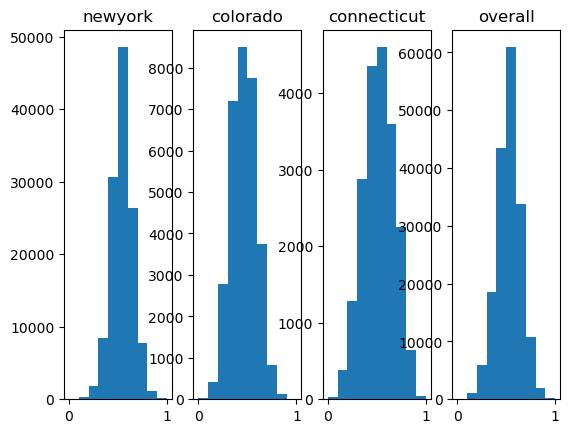

In [25]:
## histograms are plotted below to see if normalization has been done correctly

fig, axs = plt.subplots(ncols=4,nrows=1)

axs[0].hist(data_final[data_final['state']=='newyork']['score_norm'])
axs[1].hist(data_final[data_final['state']=='colorado']['score_norm'] )
axs[2].hist(data_final[data_final['state']=='connecticut']['score_norm'])
axs[3].hist(data_final['score_norm'])

axs[0].set_title('newyork')
axs[1].set_title('colorado')
axs[2].set_title('connecticut')

axs[3].set_title('overall')
plt.show()

In [26]:
### dedupe again ###
dups = data_final.duplicated(subset = ['year','school','grade','exam','state'], keep = False)

print('shape of duplicates')
print(data_final[dups].sort_values(by = ['year','school','grade','exam','state']).shape)
print('\n')

print('shape of existing final data')
print(data_final.shape)
print('\n')

data_final = data_final.drop_duplicates(subset = ['year','school','grade','exam','state'],keep = 'last',inplace=False, ignore_index=False)
print('shape of deduped final data ')
print(data_final.shape)

data_final.head()
#data_final.to_csv('C:/Users/ameen/Desktop/Covid_learning_gap_ML_project_17_oct/datasets_processed/data_final.csv')

shape of duplicates
(5203, 7)


shape of existing final data
(176585, 7)


shape of deduped final data 
(173708, 7)


,year,school,grade,exam,score,state,score_norm
3,2017,kipp academy charter school,7,maths,323,newyork,0.639241
12,2017,kipp academy charter school,8,english,313,newyork,0.575949
19,2017,kipp academy charter school,8,maths,313,newyork,0.575949
26,2017,bronx charter school for children (the),3,english,324,newyork,0.645570
38,2017,bronx charter school for children (the),3,maths,320,newyork,0.620253


# Data Enrichment Possible Ideas:

* CCD data --> look for links in the chat
* covid data --> school data hub
* district level data --> may be find out from the existing data sources?
* socio economic indicators for each district/state and year

## Next Steps:

* Merge district level info and bring indicators like county and all
* Then merge state wise district level learning model with the data set


## County Level Info Data Cleaning and Merging:

### Newyork:

In [27]:
path = 'C:/Users/ameen/Desktop/Covid_learning_gap_ML_project_17_oct'
df_dist = pd.read_excel(path+'/datasets/district_info_all_states/district_level_info.xlsx', header = 0)

In [28]:
convert_to_string(df_dist,['DistrictName','StateName','CountyName'])
df_dist = df_dist.query('StateName in ("newyork","connecticut","colorado")') 
df_dist.columns = df_dist.columns.str.lower() 
df_dist.head()

,districtname,statename,ncesdistrictid,statefips,countyfips,countyname,ziplocation,zip4location,zipmailing,zip4mailing
20,abbott union free school district,newyork,3602300.0,36.0,36119.0,westchester county,10533.0,1254,10533.0,1254
46,academic leadership charter school,newyork,3601001.0,36.0,36005.0,bronx county,10454.0,,10454.0,
50,academy charter school,newyork,3600997.0,36.0,36059.0,nassau county,11550.0,1314,11550.0,1314
51,academy charter school-uniondale,newyork,3601169.0,36.0,36059.0,nassau county,11553.0,,11553.0,
67,academy of health sciences charter school,newyork,3601190.0,36.0,36055.0,monroe county,14613.0,,14613.0,


In [29]:
for col in df_dist:
    print("count of blank values in", col)
    print((df_dist[col] == '    ').sum())
    
for col in df_dist:
    print("unique values in", col)
    print(df_dist[col].unique())

count of blank values in districtname
0
count of blank values in statename
0
count of blank values in ncesdistrictid
0
count of blank values in statefips
0
count of blank values in countyfips
0
count of blank values in countyname
0
count of blank values in ziplocation
0
count of blank values in zip4location
669
count of blank values in zipmailing
0
count of blank values in zip4mailing
643
unique values in districtname
['abbott union free school district' 'academic leadership charter school'
 'academy charter school' ... 'yuma 1 school district'
 'zeta charter school - bronx 1' 'zeta charter school - inwood 1']
unique values in statename
['newyork' 'colorado' 'connecticut']
unique values in ncesdistrictid
[3602300. 3601001. 3600997. ...  800016. 3601177. 3601171.]
unique values in statefips
[36.  8.  9.]
unique values in countyfips
[36119. 36005. 36059. 36055. 36081.  8041. 36047.  9001.  9003.  8001.
  8005. 36101. 36065. 36017.  8039.  8071. 36029.  8121.  8003. 36001.
 36073. 36037. 

In [30]:
print('shape before deduping')
print(df_dist.shape)
print('\n')
df_dist = df_dist.drop_duplicates(subset = ['districtname','statename'],keep = 'last', ignore_index = False, inplace = False)

print('shape after deduping')
print(df_dist.shape)
print('\n')

df_dist = df_dist[['districtname','statename','countyname','ncesdistrictid','statefips','countyfips','ziplocation']] 

shape before deduping
(1562, 10)


shape after deduping
(1540, 10)




In [31]:
## level 1 join
data_final_1 = data_final.merge(df_dist, how = 'left', left_on = ['school','state'], right_on = ['districtname','statename'], indicator = True)

In [32]:
print(data_final_1['_merge'].value_counts())
print(data_final_1.groupby(['state','_merge'])['year'].count())
data_final_1['_merge'] = data_final_1['_merge'].astype('string')

rel_cols = ['year','school','grade','exam','score','state','score_norm']
data_final_join_1 =  data_final_1[(data_final_1['_merge'] == 'both') & (data_final_1['state'] == 'newyork')]
data_final_step_2 =  data_final_1[(data_final_1['_merge'] != 'both') & (data_final_1['state'] == 'newyork')][rel_cols]

print('unjoined data with district')
print(data_final_step_2.shape)

left_only     137604
both           36104
right_only         0
Name: _merge, dtype: int64
state        _merge    
colorado     left_only     29981
             right_only        0
             both              0
connecticut  left_only     19711
             right_only        0
             both              0
newyork      left_only     87912
             right_only        0
             both          36104
Name: year, dtype: int64
unjoined data with district
(87912, 7)


In [33]:
data_final_step_2['first_word_school'] = data_final_step_2['school'].apply(lambda x: (str(x).split()[0]))
df_dist['first_word_districtname'] = df_dist['districtname'].apply(lambda x: (str(x).split()[0]))

In [34]:
## level 2 join
df_dist_ny = df_dist[df_dist['statename'] == 'newyork'] 
data_final_2 = data_final_step_2.merge(df_dist_ny, how = 'left', left_on = ['first_word_school','state'], right_on = ['first_word_districtname','statename'], indicator = True)
data_final_2.shape

(189448, 17)

In [35]:
print(data_final_2['_merge'].value_counts())
print(data_final_2.groupby(['state','_merge'])['year'].count())
data_final_2['_merge'] = data_final_2['_merge'].astype('string')

both          136471
left_only      52977
right_only         0
Name: _merge, dtype: int64
state    _merge    
newyork  left_only      52977
         right_only         0
         both          136471
Name: year, dtype: int64


In [36]:
data_final_2.head()

,year,school,grade,exam,score,state,score_norm,first_word_school,districtname,statename,countyname,ncesdistrictid,statefips,countyfips,ziplocation,first_word_districtname,_merge
0,2017,bronx charter school for children (the),3,english,324,newyork,0.64557,bronx,bronx academy of promise charter school,newyork,bronx county,3600956.0,36.0,36005.0,10452.0,bronx,both
1,2017,bronx charter school for children (the),3,english,324,newyork,0.64557,bronx,bronx arts and science charter school,newyork,bronx county,3601199.0,36.0,36005.0,10465.0,bronx,both
2,2017,bronx charter school for children (the),3,english,324,newyork,0.64557,bronx,bronx charter school for better learning,newyork,bronx county,3600089.0,36.0,36005.0,10466.0,bronx,both
3,2017,bronx charter school for children (the),3,english,324,newyork,0.64557,bronx,bronx charter school for better learning ii,newyork,bronx county,3601127.0,36.0,36005.0,10469.0,bronx,both
4,2017,bronx charter school for children (the),3,english,324,newyork,0.64557,bronx,bronx charter school for children,newyork,bronx county,3600110.0,36.0,36005.0,10454.0,bronx,both


In [37]:
data_final_2_dedupe = data_final_2.drop_duplicates(subset = ['year','school','grade','exam','score','state','_merge'], keep = 'last', ignore_index = False, inplace = False)
data_final_2_dedupe.shape

(87912, 17)

In [38]:
print(data_final_2_dedupe['_merge'].value_counts())
print(data_final_2_dedupe.groupby(['state','_merge'])['year'].count())
data_final_2_dedupe['_merge'] = data_final_2_dedupe['_merge'].astype('string')

left_only    52977
both         34935
Name: _merge, dtype: Int64
state    _merge   
newyork  both         34935
         left_only    52977
Name: year, dtype: int64


C:\Users\ameen\AppData\Local\Temp\ipykernel_28344\699664336.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_final_2_dedupe['_merge'] = data_final_2_dedupe['_merge'].astype('string')


In [39]:
data_final_join_2 =  data_final_2_dedupe[(data_final_2_dedupe['_merge'] == 'both') & (data_final_2_dedupe['state'] == 'newyork')]
data_final_join_2.shape 

(34935, 17)

In [40]:
rel_cols = ['year', 'school', 'grade', 'exam', 'score', 'state', 'score_norm', 'districtname','countyname', 'ncesdistrictid','statefips', 'countyfips', 'ziplocation',]
data_final_join_1 = data_final_join_1[rel_cols]
data_final_join_2 = data_final_join_2[rel_cols]

data_final_ny_with_county = pd.concat([data_final_join_1,data_final_join_2])
data_final_ny_with_county.head()

,year,school,grade,exam,score,state,score_norm,districtname,countyname,ncesdistrictid,statefips,countyfips,ziplocation
0,2017,kipp academy charter school,7,maths,323,newyork,0.639241,kipp academy charter school,bronx county,3600054.0,36.0,36005.0,10451.0
1,2017,kipp academy charter school,8,english,313,newyork,0.575949,kipp academy charter school,bronx county,3600054.0,36.0,36005.0,10451.0
2,2017,kipp academy charter school,8,maths,313,newyork,0.575949,kipp academy charter school,bronx county,3600054.0,36.0,36005.0,10451.0
113,2017,albany city school district,3,english,285,newyork,0.398734,albany city school district,albany county,3602460.0,36.0,36001.0,12207.0
114,2017,albany city school district,3,maths,283,newyork,0.386076,albany city school district,albany county,3602460.0,36.0,36001.0,12207.0


### Colorado and Connecticut:

In [41]:
df_col_dist_map = pd.read_csv(path+'/datasets_processed/colorado_school_dist_mapping.csv', header = 0)
df_con_dist_map = pd.read_csv(path+'/datasets_processed/connecticut_school_dist_mapping.csv', header = 0)

In [42]:
data_final_colorado = data_final[data_final['state'] == 'colorado']
data_final_col_1 = data_final_colorado.merge(df_col_dist_map, how = 'left', left_on = ['school','state'], right_on = ['school','state'], indicator = True, suffixes = ('_orig','_map'))
print(data_final_col_1['_merge'].value_counts())

print('shape of orignal table:')
print(data_final_colorado.shape)
print('\n')
print('shape of joined table:')
print(data_final_col_1.shape)

data_final_col_1_dedupe = data_final_col_1.drop_duplicates(subset = ['year','school','grade','exam','score','state','_merge'], keep = 'last', ignore_index = False, inplace = False)

print('shape of joined dedupe table:')
print(data_final_col_1_dedupe.shape)


data_final_col_2 = data_final_col_1_dedupe[['year','school','grade','exam','score','state','score_norm','district']]


both          33352
left_only         0
right_only        0
Name: _merge, dtype: int64
shape of orignal table:
(29981, 7)


shape of joined table:
(33352, 9)
shape of joined dedupe table:
(29981, 9)


In [43]:
data_final_col_2.head()

,year,school,grade,exam,score,state,score_norm,district
0,2017,academy endeavour elementary school,3,english,752,colorado,0.565217,academy 20
1,2017,academy international elementary school,3,english,754,colorado,0.579710,academy 20
2,2017,antelope trails elementary school,3,english,749,colorado,0.543478,academy 20
3,2017,chinook trail elementary school,3,english,774,colorado,0.724638,academy 20
4,2017,the classical academy charter,3,english,756,colorado,0.594203,academy 20


In [44]:
data_final_connecticut = data_final[data_final['state'] == 'connecticut']
data_final_con_1 = data_final_connecticut.merge(df_con_dist_map, how = 'left', left_on = ['school','state'], right_on = ['school','state'], indicator = True, suffixes = ('_orig','_map'))
print(data_final_con_1['_merge'].value_counts())

print('shape of orignal table:')
print(data_final_connecticut.shape)
print('\n')
print('shape of joined table:')
print(data_final_con_1.shape)

data_final_con_1_dedupe = data_final_con_1.drop_duplicates(subset = ['year','school','grade','exam','score','state','_merge'], keep = 'last', ignore_index = False, inplace = False)

print('shape of joined dedupe table:')
print(data_final_con_1_dedupe.shape)


data_final_con_2 = data_final_con_1_dedupe[['year','school','grade','exam','score','state','score_norm','district']]

both          20357
left_only         0
right_only        0
Name: _merge, dtype: int64
shape of orignal table:
(19711, 7)


shape of joined table:
(20357, 9)
shape of joined dedupe table:
(19711, 9)


In [45]:
data_final_col_con = pd.concat([data_final_col_2,data_final_con_2])
data_final_col_con.head()

,year,school,grade,exam,score,state,score_norm,district
0,2017,academy endeavour elementary school,3,english,752,colorado,0.565217,academy 20
1,2017,academy international elementary school,3,english,754,colorado,0.579710,academy 20
2,2017,antelope trails elementary school,3,english,749,colorado,0.543478,academy 20
3,2017,chinook trail elementary school,3,english,774,colorado,0.724638,academy 20
4,2017,the classical academy charter,3,english,756,colorado,0.594203,academy 20


In [46]:
df_dist_col_con = df_dist.query('statename in ("connecticut","colorado")')
data_col_con_county_step_1 =  data_final_col_con.merge(df_dist_col_con, how = 'left', left_on = ['district','state'], right_on = ['districtname','statename'], indicator = True)
data_col_con_county_step_1.head()

,year,school,grade,exam,score,state,score_norm,district,districtname,statename,countyname,ncesdistrictid,statefips,countyfips,ziplocation,first_word_districtname,_merge
0,2017,academy endeavour elementary school,3,english,752,colorado,0.565217,academy 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,2017,academy international elementary school,3,english,754,colorado,0.579710,academy 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,2017,antelope trails elementary school,3,english,749,colorado,0.543478,academy 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,2017,chinook trail elementary school,3,english,774,colorado,0.724638,academy 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,2017,the classical academy charter,3,english,756,colorado,0.594203,academy 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [47]:
data_col_con_county_step_1.groupby(['state','_merge'])['year'].count()

state        _merge    
colorado     left_only     26523
             right_only        0
             both           3458
connecticut  left_only        28
             right_only        0
             both          19683
Name: year, dtype: int64

In [48]:
rel_cols = ['year','school','grade','exam','score','state','score_norm','district']
data_col_con_county_join_1 = data_col_con_county_step_1[data_col_con_county_step_1['_merge'] == 'both']
data_col_con_county_step_2 = data_col_con_county_step_1[data_col_con_county_step_1['_merge'] != 'both'][rel_cols]

In [49]:
data_col_con_county_step_2_unqiue_district = data_col_con_county_step_2.drop_duplicates(subset = ['district','state'],keep = 'last', ignore_index = False, inplace = False)
data_col_con_county_step_2_unqiue_district = data_col_con_county_step_2_unqiue_district[['district','state']] 
data_col_con_county_step_2_unqiue_district_copy = data_col_con_county_step_2_unqiue_district

In [50]:
## getting mapping for district in main data and districtname in df_dist.

# Columns to match on from df_left
left_on = ["district"]

# Columns to match on from df_right
right_on = ["districtname"]

# The link table potentially contains several matches for each record
district_districtname_map = link_table(data_col_con_county_step_2_unqiue_district, df_dist_col_con, left_on, right_on)

##selecting map with highest rank
district_districtname_map = district_districtname_map.query("match_rank == 1")[['district','districtname']]
district_districtname_map.head()

##dedupe the mapping 
district_districtname_map_dedup = district_districtname_map.drop_duplicates(subset = ['district'], keep = 'last', ignore_index = False, inplace = False)
print("shape of orig dataframe: ")
print(district_districtname_map.shape)
print("\n")
print("shape of dedup dataframe: ")
print(district_districtname_map_dedup.shape)

##save the file
#district_districtname_map.to_csv('C:/Users/ameen/Desktop/Covid_learning_gap_ML_project_17_oct/datasets_processed/district_districtname_map.csv')

shape of orig dataframe: 
(153, 2)


shape of dedup dataframe: 
(153, 2)


In [51]:
data_col_con_county_step_3_temp = data_col_con_county_step_2.merge(district_districtname_map, how = 'left', left_on = ['district'], right_on = ['district'])
#print(data_col_con_county_step_3_temp.groupby(['state','_merge'])['year'].count())

## checking for duplicates
dupes = data_col_con_county_step_3_temp.duplicated(subset=['year','school','grade','exam','score','state','district','districtname'])
data_col_con_county_step_3_temp[dupes] ## no duplicates exists

## make main data table
data_col_con_county_step_3 =  data_col_con_county_step_3_temp.merge(df_dist_col_con, how = 'left', left_on = ['districtname','state'], right_on = ['districtname','statename'], indicator = True)

In [52]:
print(data_col_con_county_step_3.groupby(['state','_merge'])['year'].count())
print(data_col_con_county_step_3_temp.shape)
print(data_col_con_county_step_3.shape)

rel_cols = ['year', 'school', 'grade', 'exam', 'score', 'state', 'score_norm', 'districtname', 'countyname', 'ncesdistrictid', 'statefips','countyfips', 'ziplocation']
data_col_con_county_join_2 = (data_col_con_county_step_3[data_col_con_county_step_3['_merge'] == 'both'])[rel_cols]
data_col_con_county_join_1 = data_col_con_county_join_1[rel_cols]
data_col_con_county_join_2.head()

state        _merge    
colorado     left_only        30
             right_only        0
             both          26493
connecticut  left_only         0
             right_only        0
             both             28
Name: year, dtype: int64
(26551, 9)
(26551, 17)


,year,school,grade,exam,score,state,score_norm,districtname,countyname,ncesdistrictid,statefips,countyfips,ziplocation
0,2017,academy endeavour elementary school,3,english,752,colorado,0.565217,el paso 20 academy,el paso county,800225.0,8.0,8041.0,80920.0
1,2017,academy international elementary school,3,english,754,colorado,0.579710,el paso 20 academy,el paso county,800225.0,8.0,8041.0,80920.0
2,2017,antelope trails elementary school,3,english,749,colorado,0.543478,el paso 20 academy,el paso county,800225.0,8.0,8041.0,80920.0
3,2017,chinook trail elementary school,3,english,774,colorado,0.724638,el paso 20 academy,el paso county,800225.0,8.0,8041.0,80920.0
4,2017,the classical academy charter,3,english,756,colorado,0.594203,el paso 20 academy,el paso county,800225.0,8.0,8041.0,80920.0


In [53]:
data_col_con_county_join_1.head()

,year,school,grade,exam,score,state,score_norm,districtname,countyname,ncesdistrictid,statefips,countyfips,ziplocation
136,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,8.0,8001.0,80241.0
137,2017,meridian elementary school,3,english,763,colorado,0.644928,adams 12 five star schools,adams county,806900.0,8.0,8001.0,80241.0
138,2017,arapahoe ridge elementary school,3,english,739,colorado,0.471014,adams 12 five star schools,adams county,806900.0,8.0,8001.0,80241.0
139,2017,stargate charter school,3,english,752,colorado,0.565217,adams 12 five star schools,adams county,806900.0,8.0,8001.0,80241.0
140,2017,coronado hills elementary school,3,english,702,colorado,0.202899,adams 12 five star schools,adams county,806900.0,8.0,8001.0,80241.0


In [54]:
data_final_col_con_with_county = pd.concat([data_col_con_county_join_1,data_col_con_county_join_2])
print(data_final_col_con.shape)
print(data_final_col_con_with_county.shape)

(49692, 8)
(49662, 13)


## Final Table with County Names:

In [55]:
data_final_with_county = pd.concat([data_final_col_con_with_county,data_final_ny_with_county])

In [56]:
print(data_final_with_county.shape)

#data_final_with_county.to_csv('C:/Users/ameen/Desktop/Covid_learning_gap_ML_project_17_oct/datasets_processed/data_with_county.csv')
data_final_with_county['countyfips'] = data_final_with_county['countyfips'].astype('int')
data_final_with_county.head()

(120701, 13)


,year,school,grade,exam,score,state,score_norm,districtname,countyname,ncesdistrictid,statefips,countyfips,ziplocation
136,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,8.0,8001,80241.0
137,2017,meridian elementary school,3,english,763,colorado,0.644928,adams 12 five star schools,adams county,806900.0,8.0,8001,80241.0
138,2017,arapahoe ridge elementary school,3,english,739,colorado,0.471014,adams 12 five star schools,adams county,806900.0,8.0,8001,80241.0
139,2017,stargate charter school,3,english,752,colorado,0.565217,adams 12 five star schools,adams county,806900.0,8.0,8001,80241.0
140,2017,coronado hills elementary school,3,english,702,colorado,0.202899,adams 12 five star schools,adams county,806900.0,8.0,8001,80241.0


## Socio Economic Indicators Merging:

### Unemployment:
* Join by FIPS id, and bring years of data.
* Join each socio economic indicator file with the above data (Employment, Population, Poverty, Education)
* Join key: County and Year

In [57]:
path_df1 = '/datasets/data_enrichment/umeployment/UnemploymentReport_col.xlsx'
path_df2 = '/datasets/data_enrichment/umeployment/UnemploymentReport_con.xlsx'
path_df3 = '/datasets/data_enrichment/umeployment/UnemploymentReport_ny.xlsx'
unemp_col,unemp_con,unemp_ny =  format_employment(path_df1),format_employment(path_df2),format_employment(path_df3)

In [58]:
data_check(unemp_col)

Unique Values
<bound method Series.unique of 0     8001
1     8003
2     8005
3     8007
4     8009
      ... 
59    8117
60    8119
61    8121
62    8123
63    8125
Name: FIPS, Length: 64, dtype: int64>
<bound method Series.unique of 0          Adams County, CO
1        Alamosa County, CO
2       Arapahoe County, CO
3      Archuleta County, CO
4           Baca County, CO
              ...          
59        Summit County, CO
60        Teller County, CO
61    Washington County, CO
62          Weld County, CO
63          Yuma County, CO
Name: Name, Length: 64, dtype: object>
<bound method Series.unique of 0     8.0
1     9.6
2     6.5
3     8.6
4     4.1
     ... 
59    4.9
60    7.7
61    4.5
62    6.5
63    4.7
Name: 2013, Length: 64, dtype: float64>
<bound method Series.unique of 0     5.7
1     7.2
2     4.9
3     6.0
4     2.8
     ... 
59    3.4
60    5.8
61    3.1
62    4.4
63    3.3
Name: 2014, Length: 64, dtype: float64>
<bound method Series.unique of 0     4.2
1     5.0
2    

In [59]:
data_check(unemp_con)

Unique Values
<bound method Series.unique of 0    9001
1    9003
2    9005
3    9007
4    9009
5    9011
6    9013
7    9015
Name: FIPS, dtype: int64>
<bound method Series.unique of 0     Fairfield County, CT
1      Hartford County, CT
2    Litchfield County, CT
3     Middlesex County, CT
4     New Haven County, CT
5    New London County, CT
6       Tolland County, CT
7       Windham County, CT
Name: Name, dtype: object>
<bound method Series.unique of 0    7.4
1    8.1
2    7.3
3    6.8
4    8.7
5    8.3
6    7.0
7    9.0
Name: 2013, dtype: float64>
<bound method Series.unique of 0    6.2
1    6.8
2    6.0
3    5.7
4    7.2
5    6.8
6    5.8
7    7.4
Name: 2014, dtype: float64>
<bound method Series.unique of 0    5.3
1    5.8
2    5.1
3    4.8
4    6.1
5    5.8
6    4.9
7    6.3
Name: 2015, dtype: float64>
<bound method Series.unique of 0    4.6
1    5.0
2    4.5
3    4.2
4    5.2
5    4.8
6    4.2
7    5.3
Name: 2016, dtype: float64>
<bound method Series.unique of 0    4.3
1    4.6
2 

In [60]:
data_check(unemp_ny)

Unique Values
<bound method Series.unique of 0     36001
1     36003
2     36005
3     36007
4     36009
      ...  
57    36115
58    36117
59    36119
60    36121
61    36123
Name: FIPS, Length: 62, dtype: int64>
<bound method Series.unique of 0          Albany County, NY
1        Allegany County, NY
2           Bronx County, NY
3          Broome County, NY
4     Cattaraugus County, NY
               ...          
57     Washington County, NY
58          Wayne County, NY
59    Westchester County, NY
60        Wyoming County, NY
61          Yates County, NY
Name: Name, Length: 62, dtype: object>
<bound method Series.unique of 0      6.2
1      7.7
2     11.7
3      8.0
4      8.7
      ... 
57     7.7
58     7.8
59     6.4
60     8.1
61     7.0
Name: 2013, Length: 62, dtype: float64>
<bound method Series.unique of 0     4.9
1     6.3
2     9.5
3     6.7
4     7.1
     ... 
57    6.1
58    6.2
59    5.2
60    6.6
61    5.7
Name: 2014, Length: 62, dtype: float64>
<bound method Series.un

In [61]:
unemp_data = pd.concat([unemp_ny,unemp_col,unemp_con])
unemp_data_fin = unemp_data.melt(id_vars=["FIPS",'Name'], 
        var_name="Year", 
        value_name="unemp_rate")
unemp_data_fin['Year'] = unemp_data_fin['Year'].astype('int') 
unemp_data_fin.head()

,FIPS,Name,Year,unemp_rate
0,36001,"Albany County, NY",2013,6.2
1,36003,"Allegany County, NY",2013,7.7
2,36005,"Bronx County, NY",2013,11.7
3,36007,"Broome County, NY",2013,8.0
4,36009,"Cattaraugus County, NY",2013,8.7


In [62]:
data_final_2 = data_final_with_county.merge(unemp_data_fin, how = 'left', left_on = ['countyfips','year'], right_on = ['FIPS','Year'], indicator = True)
print(data_final_2.groupby(['state','_merge'])['year'].count())
rel_cols = ['year', 'school', 'grade', 'exam', 'score', 'state', 'score_norm','districtname', 'countyname', 'ncesdistrictid', 'statefips',
       'countyfips', 'ziplocation','Name', 'unemp_rate']
data_final_2 = data_final_2[rel_cols]
data_final_2.head()

state        _merge    
colorado     left_only         0
             right_only        0
             both          29951
connecticut  left_only         0
             right_only        0
             both          19711
newyork      left_only         0
             right_only        0
             both          71039
Name: year, dtype: int64


,year,school,grade,exam,score,state,score_norm,districtname,countyname,ncesdistrictid,statefips,countyfips,ziplocation,Name,unemp_rate
0,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,8.0,8001,80241.0,"Adams County, CO",2.8
1,2017,meridian elementary school,3,english,763,colorado,0.644928,adams 12 five star schools,adams county,806900.0,8.0,8001,80241.0,"Adams County, CO",2.8
2,2017,arapahoe ridge elementary school,3,english,739,colorado,0.471014,adams 12 five star schools,adams county,806900.0,8.0,8001,80241.0,"Adams County, CO",2.8
3,2017,stargate charter school,3,english,752,colorado,0.565217,adams 12 five star schools,adams county,806900.0,8.0,8001,80241.0,"Adams County, CO",2.8
4,2017,coronado hills elementary school,3,english,702,colorado,0.202899,adams 12 five star schools,adams county,806900.0,8.0,8001,80241.0,"Adams County, CO",2.8


### Population Data:

In [63]:
path_df1 = '/datasets/data_enrichment/population_county/processed/population_19.xlsx'
pop_19 = pd.read_excel(path+path_df1,header = 0)
pop_19 = pop_19.query("YEAR in (12,11,10)") 
pop_19['YEAR'] = pop_19['YEAR'].replace(12,2019)
pop_19['YEAR'] = pop_19['YEAR'].replace(11,2018)
pop_19['YEAR'] = pop_19['YEAR'].replace(10,2017)
rel_cols = ['STNAME', 'CTYNAME', 'YEAR',
       'POPESTIMATE']
pop_19 = pop_19[rel_cols]
#dups = pop_19.duplicated(subset = ['STNAME','CTYNAME','YEAR'])
#pop_19[dups] no dups
pop_19.columns = ['State','County','Year','pop_estimate']
pop_19.head()

,State,County,Year,pop_estimate
9,Colorado,Adams County,2017,503590
10,Colorado,Adams County,2018,511354
11,Colorado,Adams County,2019,517421
21,Colorado,Alamosa County,2017,16108
22,Colorado,Alamosa County,2018,16248


In [64]:
path_df1 = '/datasets/data_enrichment/population_county/processed/population_20_21.xlsx'
pop_20 = pd.read_excel(path+path_df1,header = 0)
pop_20[['County','State']] = pop_20.Area.str.split(",",expand=True,)
rel_cols = ['County', 'State', 2020,2021]
pop_20 = pop_20[rel_cols]
pop_20_v2 = pop_20.melt(id_vars=["County",'State'], 
        var_name="Year", 
        value_name="pop_estimate")
pop_20_v2.head()

,County,State,Year,pop_estimate
0,.Adams County,Colorado,2020,520163
1,.Alamosa County,Colorado,2020,16362
2,.Arapahoe County,Colorado,2020,655112
3,.Archuleta County,Colorado,2020,13424
4,.Baca County,Colorado,2020,3486


In [65]:
pop_data = pd.concat([pop_19,pop_20_v2])
convert_to_string(pop_data,['State','County'])
pop_data.head()

,State,County,Year,pop_estimate
9,colorado,adams county,2017,503590
10,colorado,adams county,2018,511354
11,colorado,adams county,2019,517421
21,colorado,alamosa county,2017,16108
22,colorado,alamosa county,2018,16248


In [66]:
#left_on = ["countyname"]
#right_on = ["County"]

right_on = ["countyname"]
left_on = ["County"]


# The link table potentially contains several matches for each record
data_final_2_pop_data_map = link_table(pop_data,data_final_2, left_on, right_on)

In [67]:
##selecting map with highest rank
data_final_2_pop_data_map = data_final_2_pop_data_map.query("match_rank == 1")[['countyname','County']]
data_final_2_pop_data_map.head()

##dedupe the mapping 
data_final_2_pop_data_map_dedup = data_final_2_pop_data_map.drop_duplicates(subset = ['countyname','County'], keep = 'last', ignore_index = False, inplace = False)
print("shape of orig dataframe: ")
print(data_final_2_pop_data_map.shape)
print("\n")
print("shape of dedup dataframe: ")
print(data_final_2_pop_data_map_dedup.shape)

shape of orig dataframe: 
(670, 2)


shape of dedup dataframe: 
(264, 2)


In [68]:
data_final_2_pop_data_map_dedup.head()

,countyname,County
100,adams county,adams county
250,alamosa county,alamosa county
400,arapahoe county,arapahoe county
550,archuleta county,archuleta county
676,baca county,baca county


In [69]:
pop_data_final =  pop_data.merge(data_final_2_pop_data_map_dedup, how = 'left', left_on = ['County'], right_on = ['County'])
pop_data_final['pop_estimate_norm'] = min_max_norm(pop_data_final,'pop_estimate')
rel_cols = ['State','countyname','Year','pop_estimate_norm']
pop_data_final = pop_data_final[rel_cols]
pop_data_final.head()

,State,countyname,Year,pop_estimate_norm
0,colorado,adams county,2017,0.184429
1,colorado,adams county,2018,0.187277
2,colorado,adams county,2019,0.189502
3,colorado,alamosa county,2017,0.005647
4,colorado,alamosa county,2018,0.005698


In [70]:
pop_data_final.groupby('State')['countyname'].unique()

State
 colorado       [adams county, alamosa county, arapahoe county...
 connecticut    [fairfield county, hartford county, litchfield...
 new york       [albany county, allegany county, bronx county,...
colorado        [adams county, alamosa county, arapahoe county...
connecticut     [fairfield county, hartford county, litchfield...
new york        [albany county, allegany county, bronx county,...
Name: countyname, dtype: object

In [71]:
data_final_3 = data_final_2.merge(pop_data_final, how = 'left', left_on = ['countyname','year'], right_on = ['countyname','Year',], indicator = True)
print(data_final_3.groupby(['state','_merge'])['year'].count())

state        _merge    
colorado     left_only         0
             right_only        0
             both          51963
connecticut  left_only         0
             right_only        0
             both          24736
newyork      left_only      3480
             right_only        0
             both          69430
Name: year, dtype: int64


In [72]:
data_final_4 = data_final_3.query("_merge == 'both'")
data_final_4 = data_final_4.drop(['State','Year','_merge'], axis=1)
data_final_4.head()

,year,school,grade,exam,score,state,score_norm,districtname,countyname,ncesdistrictid,statefips,countyfips,ziplocation,Name,unemp_rate,pop_estimate_norm
0,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,8.0,8001,80241.0,"Adams County, CO",2.8,0.184429
1,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,8.0,8001,80241.0,"Adams County, CO",2.8,0.024775
2,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,8.0,8001,80241.0,"Adams County, CO",2.8,0.000419
3,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,8.0,8001,80241.0,"Adams County, CO",2.8,0.000490
4,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,8.0,8001,80241.0,"Adams County, CO",2.8,0.000030


### SAIPE Data:

In [73]:
path_df1 = path + '/datasets/data_enrichment/SAIPE_est/est_17.xlsx'
path_df2 = path + '/datasets/data_enrichment/SAIPE_est/est_18.xlsx'
path_df3 = path + '/datasets/data_enrichment/SAIPE_est/est_19.xlsx'
path_df4 = path + '/datasets/data_enrichment/SAIPE_est/est_20.xlsx'

read_table = lambda main_path: pd.read_excel(main_path, header = None)

est_17,est_18,est_19,est_20 = read_table(path_df1),read_table(path_df2),read_table(path_df3),read_table(path_df4)

In [74]:
cols =  ['FIPS_State'
,'FIPS_county'
,'poverty_all_ages'
,'a'
,'b'
,'poverty_all_ages_perc'
,'c'
,'d'
,'poverty_0_17'
,'e'
,'f'
,'poverty_0_17_perc'
,'g'
,'h'
,'poverty_rel_children_5_17'
,'i'
,'j'
,'poverty_rel_children_5_17_perc'
,'k'
,'l'
,'median_income'
,'m'
,'n'
,'countyname'
,'Two-letter Postal State abbreviation'
,'A tag indicating the file name and date of creation'
,'date']

est_17.columns = cols
est_18.columns = cols
est_19.columns = cols
est_20.columns = cols

est_17['year'] = '2017'
est_18['year'] = '2018'
est_19['year'] = '2019'
est_20['year'] = '2021'

In [75]:
saipe_data_v1 = pd.concat([est_17,est_18,est_19,est_20])
rel_cols = ['countyname','year','poverty_all_ages_perc','poverty_0_17_perc','poverty_rel_children_5_17_perc','median_income']
saipe_data_v1 = saipe_data_v1[rel_cols] 
convert_to_string(saipe_data_v1,['countyname'])
saipe_data_v1['year'] = saipe_data_v1['year'].astype('int') 

In [76]:
print(saipe_data_v1['countyname'].value_counts().shape)
print(data_final_4['countyname'].value_counts().shape)

(144,)
(125,)


In [77]:
right_on = ["countyname"]
left_on = ["countyname"]

# The link table potentially contains several matches for each record
data_final_4_saipe_data_map = link_table(data_final_4,saipe_data_v1, left_on, right_on)
data_final_4_saipe_data_map.head()

##selecting map with highest rank
data_final_4_saipe_data_map = data_final_4_saipe_data_map.query("match_rank == 1")[['countyname_left','countyname_right']]
data_final_4_saipe_data_map.head()

##dedupe the mapping 
data_final_4_saipe_data_map_dedup = data_final_4_saipe_data_map.drop_duplicates(subset = ['countyname_left','countyname_right'], keep = 'last', ignore_index = False, inplace = False)
print("shape of orig dataframe: ")
print(data_final_4_saipe_data_map.shape)
print("\n")
print("shape of dedup dataframe: ")
print(data_final_4_saipe_data_map_dedup.shape)

shape of orig dataframe: 
(146129, 2)


shape of dedup dataframe: 
(125, 2)


In [78]:
saipe_data_final =  saipe_data_v1.merge(data_final_4_saipe_data_map_dedup, how = 'left', left_on = ['countyname'], right_on = ['countyname_right'])
saipe_data_final.columns
rel_cols = ['countyname_left','year','poverty_all_ages_perc', 'poverty_0_17_perc','poverty_rel_children_5_17_perc', 'median_income']
saipe_data_final = saipe_data_final[rel_cols]
saipe_data_final.head()

,countyname_left,year,poverty_all_ages_perc,poverty_0_17_perc,poverty_rel_children_5_17_perc,median_income
0,NaN,2017,10.3,12.2,11.4,69113
1,adams county,2017,10.6,13.7,12.4,65977
2,alamosa county,2017,21.3,26.6,25.4,43121
3,arapahoe county,2017,7.8,9.0,8.2,75196
4,archuleta county,2017,11.7,21.0,20.3,52481


In [79]:
data_final_5 = data_final_4.merge(saipe_data_final, how = 'left', left_on = ['countyname','year'], right_on = ['countyname_left','year',], indicator = True)
print(data_final_5.groupby(['state','_merge'])['year'].count())

state        _merge    
colorado     left_only         0
             right_only        0
             both          58637
connecticut  left_only         0
             right_only        0
             both          24736
newyork      left_only         0
             right_only        0
             both          73172
Name: year, dtype: int64


In [80]:
data_final_5 = data_final_5.drop(['_merge'],axis = 1)
data_final_5.head()

,year,school,grade,exam,score,state,score_norm,districtname,countyname,ncesdistrictid,...,countyfips,ziplocation,Name,unemp_rate,pop_estimate_norm,countyname_left,poverty_all_ages_perc,poverty_0_17_perc,poverty_rel_children_5_17_perc,median_income
0,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,8001,80241.0,"Adams County, CO",2.8,0.184429,adams county,10.6,13.7,12.4,65977
1,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,8001,80241.0,"Adams County, CO",2.8,0.024775,adams county,10.6,13.7,12.4,65977
2,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,8001,80241.0,"Adams County, CO",2.8,0.000419,adams county,10.6,13.7,12.4,65977
3,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,8001,80241.0,"Adams County, CO",2.8,0.000490,adams county,10.6,13.7,12.4,65977
4,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,8001,80241.0,"Adams County, CO",2.8,0.000030,adams county,10.6,13.7,12.4,65977


## Covid-19 Learning Data:

### Colorado:
* Covid-19 Cases data: 
    Joining key: SchoolName, State. TimePeriodEnd and TimePeriodStart needs to be used for extracting year
    Columns to be used: Newcasesstudents, Newcasesstaff, Newcasescombined. Note: Only for 2020 and 2021
* Masking Policy: district level data. Joining criteria: district name. Note: Only for 2020 and 2021.
* Learning Model Data: joining criteria: district, time. Duration: Weekly (need to change), Columns to use: Learning Model

### Connecticut:
* Covid-19 Cases data:
        Joining key: SchoolName, State. TimePeriodEnd and TimePeriodStart needs to be used for extracting year. Data interval:
        weekly
        Columns to be used: Activecasescombined
* Masking Policy: district level data. Joining criteria: district name. Note: Only for 2020-21.
* Learning Model Data: joining criteria: school, time. Duration: Weekly (need to change), Columns to use: Learning Model

### Newyork:
* Covid-19 Cases data:
        Joining key: SchoolName, State. TimePeriodEnd and TimePeriodStart needs to be used for extracting year. Data interval:         weekly
        Columns to be used: Newcasesstudents, Newcasesstaff
* Masking Policy: district level data. Joining criteria: district name. Note: Only for 2020-21. 
* Learning Model Data: joining criteria: school, time. Duration: Weekly (need to change), Columns to use: Learning Model

### CCD data set:
* join criteria: NSCESID, ziplocation
* Only available for 2020 (Can be utilized but need to see from research paper how it is utilized)

### Covid-19 Case Data:

In [81]:
path_df = path + '/datasets/data_enrichment/covid_data/COVID_Schools_Col.csv'
covid_col = pd.read_csv(path_df)
rel_cols = ['StateName','SchoolName','NCESSchoolID','NCESDistrictID' ,'TimePeriodStart','TimePeriodEnd','NewCasesCombined', 'NewCasesStudents',
       'NewCasesStaff']
covid_col = covid_col[rel_cols]
covid_col['TimePeriodStart'] = pd.to_datetime(covid_col['TimePeriodStart'])
covid_col['TimePeriodEnd'] = pd.to_datetime(covid_col['TimePeriodEnd'])
covid_col['year'] = pd.DatetimeIndex(covid_col['TimePeriodStart']).year
covid_col['NCESDistrictID'] = covid_col['NCESDistrictID'].astype('float64')
convert_to_string(covid_col,['StateName','SchoolName'])
covid_col.head()

,StateName,SchoolName,NCESSchoolID,NCESDistrictID,TimePeriodStart,TimePeriodEnd,NewCasesCombined,NewCasesStudents,NewCasesStaff,year
0,colorado,5280 high school,8.033601e+10,803360.0,2021-01-27,2021-02-14,4,4.0,NaN,2021
1,colorado,5280 high school,8.033601e+10,803360.0,2021-05-03,2021-05-29,8,8.0,NaN,2021
2,colorado,academia ana marie sandoval,8.033600e+10,803360.0,2020-11-13,2020-12-23,3,3.0,NaN,2020
3,colorado,academy charter school,8.034500e+10,803450.0,2020-11-17,2020-12-08,2,2.0,NaN,2020
4,colorado,adams city high school,8.019500e+10,801950.0,2021-05-05,2021-05-17,3,3.0,NaN,2021


In [82]:
check_na(covid_col)

StateName
0


SchoolName
0


NCESSchoolID
0


NCESDistrictID
0


TimePeriodStart
0


TimePeriodEnd
0


NewCasesCombined
0


NewCasesStudents
85


NewCasesStaff
282


year
0




In [83]:
check_unique(covid_col)

StateName
['colorado']


SchoolName
['5280 high school' 'academia ana marie sandoval' 'academy charter school'
 'adams city high school' 'addenbrooke classical academy'
 'air academy high school' 'alameda international jr/sr high'
 'alamosa elementary k-2' 'alamosa high school'
 'alicia sanchez elementary school' 'altitude elementary school'
 'altura elementary school' 'american academy - castle pines'
 'american academy - lincoln meadows' 'american academy - motsenbocker'
 'antelope trails elementary school' 'antonito high school'
 'aragon elementary' 'arapahoe high school' 'arvada west high school'
 'ashbury elementary school' 'aspen elementary school'
 'aspen view academy' 'audubon elementary school'
 'aurora hills middle school' 'aurora west college preparatory academy'
 'baca elementary school' 'bacon elementary school'
 'banning lewis ranch academy' 'barnum elementary school'
 'barone middle school' 'basalt high school' 'basalt middle school'
 'battle mountain high school' 'baude

In [84]:
new_cases_per_year_school_col = covid_col.groupby(['NCESDistrictID','year'])[['NewCasesCombined']].sum().reset_index()
new_cases_per_year_school_col['state'] = 'colorado'
new_cases_per_year_school_col_cond = covid_col.groupby(['SchoolName','year'])[['NewCasesCombined']].sum().reset_index()
new_cases_per_year_school_col.head()

,NCESDistrictID,year,NewCasesCombined,state
0,800004.0,2021,9,colorado
1,800016.0,2020,8,colorado
2,800020.0,2020,57,colorado
3,800020.0,2021,71,colorado
4,800023.0,2020,2,colorado


In [85]:
data_final_5.dtypes

year                               object
school                             object
grade                               int64
exam                               object
score                               int32
state                              object
score_norm                        float64
districtname                       object
countyname                         object
ncesdistrictid                    float64
statefips                         float64
countyfips                          int32
ziplocation                       float64
Name                               object
unemp_rate                        float64
pop_estimate_norm                 float64
countyname_left                    object
poverty_all_ages_perc             float64
poverty_0_17_perc                 float64
poverty_rel_children_5_17_perc    float64
median_income                       int64
dtype: object

In [86]:
path_df = path + '/datasets/data_enrichment/covid_data/COVID_Schools_Con.csv'
covid_con = pd.read_csv(path_df)
rel_cols = ['StateName','SchoolName','NCESSchoolID','NCESDistrictID', 'TimePeriodStart','TimePeriodEnd','NewCasesCombined']
covid_con = covid_con[rel_cols]
covid_con['TimePeriodStart'] = pd.to_datetime(covid_con['TimePeriodStart'])
covid_con['TimePeriodEnd'] = pd.to_datetime(covid_con['TimePeriodEnd'])
convert_to_string(covid_con,['StateName','SchoolName'])
covid_con['NCESDistrictID'] = covid_con['NCESDistrictID'].astype('float64')
covid_con['year'] = pd.DatetimeIndex(covid_con['TimePeriodStart']).year

covid_con.head()

,StateName,SchoolName,NCESSchoolID,NCESDistrictID,TimePeriodStart,TimePeriodEnd,NewCasesCombined,year
0,connecticut,andover elementary school,9.000301e+10,900030.0,2020-10-08,2020-10-14,NaN,2020
1,connecticut,andover elementary school,9.000301e+10,900030.0,2020-10-15,2020-10-21,NaN,2020
2,connecticut,andover elementary school,9.000301e+10,900030.0,2020-10-22,2020-10-28,NaN,2020
3,connecticut,andover elementary school,9.000301e+10,900030.0,2020-10-29,2020-11-04,NaN,2020
4,connecticut,andover elementary school,9.000301e+10,900030.0,2020-11-05,2020-11-11,NaN,2020


In [87]:
check_na(covid_con)

StateName
0


SchoolName
0


NCESSchoolID
0


NCESDistrictID
333


TimePeriodStart
0


TimePeriodEnd
0


NewCasesCombined
40774


year
0




In [88]:
covid_con.dtypes

StateName                   object
SchoolName                  object
NCESSchoolID               float64
NCESDistrictID             float64
TimePeriodStart     datetime64[ns]
TimePeriodEnd       datetime64[ns]
NewCasesCombined           float64
year                         int64
dtype: object

In [89]:
new_cases_per_year_school_con = covid_con.groupby(['NCESDistrictID','year'])[['NewCasesCombined']].sum().reset_index()
new_cases_per_year_school_con['state'] = 'connecticut'
new_cases_per_year_school_con.head()

,NCESDistrictID,year,NewCasesCombined,state
0,900002.0,2020,0.0,connecticut
1,900002.0,2021,0.0,connecticut
2,900005.0,2020,0.0,connecticut
3,900005.0,2021,0.0,connecticut
4,900007.0,2020,0.0,connecticut


In [90]:
path_df = path + '/datasets/data_enrichment/covid_data/COVID_Schools_Ny.csv'
covid_ny = pd.read_csv(path_df)
rel_cols = ['StateName','SchoolName','NCESSchoolID','NCESDistrictID', 'TimePeriodStart','TimePeriodEnd','NewCasesStudents','NewCasesStaff']
covid_ny = covid_ny[rel_cols]
covid_ny['TimePeriodStart'] = pd.to_datetime(covid_ny['TimePeriodStart'])
covid_ny['TimePeriodEnd'] = pd.to_datetime(covid_ny['TimePeriodEnd'])
convert_to_string(covid_ny,['StateName','SchoolName'])
covid_ny['NCESDistrictID'] = covid_ny['NCESDistrictID'].astype('float64')
covid_ny['NewCasesCombined'] = covid_ny['NewCasesStudents'] + covid_ny['NewCasesStaff'] 
covid_ny['year'] = pd.DatetimeIndex(covid_ny['TimePeriodStart']).year
rel_cols = ['StateName','SchoolName','NCESSchoolID', 'TimePeriodStart','TimePeriodEnd','NewCasesCombined']




covid_ny.head()


,StateName,SchoolName,NCESSchoolID,NCESDistrictID,TimePeriodStart,TimePeriodEnd,NewCasesStudents,NewCasesStaff,NewCasesCombined,year
0,new york,academic leadership charter school,3.601001e+11,3601001.0,2021-06-07,2021-06-20,0,0,0,2021
1,new york,academy charter school,3.600997e+11,3600997.0,2021-06-07,2021-06-20,0,0,0,2021
2,new york,academy charter school-uniondale,3.601169e+11,3601169.0,2021-06-07,2021-06-20,0,0,0,2021
3,new york,academy of health sciences charter school,3.601190e+11,3601190.0,2021-06-07,2021-06-20,0,0,0,2021
4,new york,academy of the city charter school,3.601053e+11,3601053.0,2021-06-07,2021-06-20,0,0,0,2021


In [91]:
check_na(covid_ny)

StateName
0


SchoolName
0


NCESSchoolID
0


NCESDistrictID
0


TimePeriodStart
0


TimePeriodEnd
0


NewCasesStudents
0


NewCasesStaff
0


NewCasesCombined
0


year
0




In [92]:
covid_ny.dtypes

StateName                   object
SchoolName                  object
NCESSchoolID               float64
NCESDistrictID             float64
TimePeriodStart     datetime64[ns]
TimePeriodEnd       datetime64[ns]
NewCasesStudents             int64
NewCasesStaff                int64
NewCasesCombined             int64
year                         int64
dtype: object

In [93]:
new_cases_per_year_school_ny = covid_ny.groupby(['NCESDistrictID','year'])[['NewCasesCombined']].sum().reset_index()
new_cases_per_year_school_ny['state'] = 'newyork'
new_cases_per_year_school_ny.head()

,NCESDistrictID,year,NewCasesCombined,state
0,3600001.0,2020,1,newyork
1,3600001.0,2021,0,newyork
2,3600002.0,2020,13,newyork
3,3600002.0,2021,28,newyork
4,3600003.0,2020,4,newyork


In [94]:
covid_data = pd.concat([new_cases_per_year_school_ny,new_cases_per_year_school_con,new_cases_per_year_school_col])
covid_data = covid_data.drop(['state'],axis = 1)
covid_data = covid_data[covid_data['year'] == 2021]
covid_data = covid_data.drop(['year'],axis = 1) 

In [95]:
covid_data[covid_data['NCESDistrictID'] == 800284]

,NCESDistrictID,NewCasesCombined


In [96]:
data_final_5.head()

,year,school,grade,exam,score,state,score_norm,districtname,countyname,ncesdistrictid,...,countyfips,ziplocation,Name,unemp_rate,pop_estimate_norm,countyname_left,poverty_all_ages_perc,poverty_0_17_perc,poverty_rel_children_5_17_perc,median_income
0,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,8001,80241.0,"Adams County, CO",2.8,0.184429,adams county,10.6,13.7,12.4,65977
1,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,8001,80241.0,"Adams County, CO",2.8,0.024775,adams county,10.6,13.7,12.4,65977
2,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,8001,80241.0,"Adams County, CO",2.8,0.000419,adams county,10.6,13.7,12.4,65977
3,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,8001,80241.0,"Adams County, CO",2.8,0.000490,adams county,10.6,13.7,12.4,65977
4,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,8001,80241.0,"Adams County, CO",2.8,0.000030,adams county,10.6,13.7,12.4,65977


In [97]:
data_final_6 = data_final_5.merge(covid_data, how = 'left', left_on = ['ncesdistrictid'], right_on = ['NCESDistrictID'], indicator = True)
data_final_6.head()

,year,school,grade,exam,score,state,score_norm,districtname,countyname,ncesdistrictid,...,unemp_rate,pop_estimate_norm,countyname_left,poverty_all_ages_perc,poverty_0_17_perc,poverty_rel_children_5_17_perc,median_income,NCESDistrictID,NewCasesCombined,_merge
0,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,2.8,0.184429,adams county,10.6,13.7,12.4,65977,806900.0,35.0,both
1,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,2.8,0.024775,adams county,10.6,13.7,12.4,65977,806900.0,35.0,both
2,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,2.8,0.000419,adams county,10.6,13.7,12.4,65977,806900.0,35.0,both
3,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,2.8,0.000490,adams county,10.6,13.7,12.4,65977,806900.0,35.0,both
4,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,2.8,0.000030,adams county,10.6,13.7,12.4,65977,806900.0,35.0,both


In [98]:
print(data_final_6.groupby(['state','year','_merge'])['year'].count())

state        year  _merge    
colorado     2017  left_only      6370
                   right_only        0
                   both          10708
             2018  left_only      6303
                   right_only        0
                   both          10486
             2019  left_only      6344
                   right_only        0
                   both          10386
             2021  left_only      3107
                   right_only        0
                   both           4933
connecticut  2017  left_only         0
                   right_only        0
                   both           6206
             2018  left_only         0
                   right_only        0
                   both           6254
             2019  left_only         0
                   right_only        0
                   both           6184
             2021  left_only         0
                   right_only        0
                   both           6092
newyork      2017  left_only      

In [99]:
condition = (data_final_6['_merge'] == 'left_only') & (data_final_6['state'] == 'colorado')
data_final_6_cond = data_final_6[condition] 
data_final_6_ncond = data_final_6[~data_final_6.index.isin(data_final_6_cond.index)]
data_final_6_cond.head()

,year,school,grade,exam,score,state,score_norm,districtname,countyname,ncesdistrictid,...,unemp_rate,pop_estimate_norm,countyname_left,poverty_all_ages_perc,poverty_0_17_perc,poverty_rel_children_5_17_perc,median_income,NCESDistrictID,NewCasesCombined,_merge
1632,2017,aspen elementary school,3,english,740,colorado,0.478261,aspen 1,pitkin county,800289.0,...,2.9,0.006331,pitkin county,5.9,6.8,6.2,78596,NaN,NaN,left_only
1633,2017,aspen community charter school,4,english,776,colorado,0.739130,aspen 1,pitkin county,800289.0,...,2.9,0.006331,pitkin county,5.9,6.8,6.2,78596,NaN,NaN,left_only
1634,2017,aspen elementary school,4,english,742,colorado,0.492754,aspen 1,pitkin county,800289.0,...,2.9,0.006331,pitkin county,5.9,6.8,6.2,78596,NaN,NaN,left_only
1635,2017,aspen middle school,5,english,749,colorado,0.543478,aspen 1,pitkin county,800289.0,...,2.9,0.006331,pitkin county,5.9,6.8,6.2,78596,NaN,NaN,left_only
1636,2017,aspen middle school,6,english,746,colorado,0.521739,aspen 1,pitkin county,800289.0,...,2.9,0.006331,pitkin county,5.9,6.8,6.2,78596,NaN,NaN,left_only


In [100]:
## getting mapping for district in main data and districtname in df_dist.

# Columns to match on from df_left
right_on = ["SchoolName"]

# Columns to match on from df_right
left_on = ["school"]

# The link table potentially contains several matches for each record
school_col_cases_map = link_table(data_final_6_cond,new_cases_per_year_school_col_cond, left_on, right_on)

school_col_cases_map = (school_col_cases_map[school_col_cases_map['match_rank'] == 1])[['SchoolName','school']]
school_col_cases_map.head()

,SchoolName,school
0,aspen elementary school,aspen elementary school
1,aspen elementary school,aspen community charter school
66,aspen elementary school,aspen elementary school
67,aspen elementary school,aspen middle school
159,aspen elementary school,aspen middle school


In [101]:
new_cases_per_year_school_col_cond_2 = new_cases_per_year_school_col_cond.merge(school_col_cases_map, left_on = ['SchoolName'], right_on = ['SchoolName'], indicator = False)
new_cases_per_year_school_col_cond_3 = new_cases_per_year_school_col_cond_2.drop_duplicates(subset = ['school'],keep = 'last',inplace=False, ignore_index=False )
new_cases_per_year_school_col_cond_3 = new_cases_per_year_school_col_cond_3.drop(['SchoolName','year'], axis = 1)
print(new_cases_per_year_school_col_cond_3['school'].unique().shape)
print(data_final_6_cond['school'].unique().shape)
new_cases_per_year_school_col_cond_3.head()

(714,)
(715,)


,NewCasesCombined,school
16,2,victory preparatory academy high state charter...
32,2,youth & family academy charter
131,2,cardinal community academy charter school
137,2,crown pointe charter academy
142,2,ricardo flores magon academy


In [102]:
data_final_6_cond = data_final_6_cond.drop(['_merge','NewCasesCombined'],axis = 1)
data_final_6_cond_2 = data_final_6_cond.merge(new_cases_per_year_school_col_cond_3, left_on = ['school'], right_on = ['school'], indicator = True)
data_final_6_cond_2.head()

,year,school,grade,exam,score,state,score_norm,districtname,countyname,ncesdistrictid,...,unemp_rate,pop_estimate_norm,countyname_left,poverty_all_ages_perc,poverty_0_17_perc,poverty_rel_children_5_17_perc,median_income,NCESDistrictID,NewCasesCombined,_merge
0,2017,aspen elementary school,3,english,740,colorado,0.478261,aspen 1,pitkin county,800289.0,...,2.9,0.006331,pitkin county,5.9,6.8,6.2,78596,NaN,2,both
1,2017,aspen elementary school,4,english,742,colorado,0.492754,aspen 1,pitkin county,800289.0,...,2.9,0.006331,pitkin county,5.9,6.8,6.2,78596,NaN,2,both
2,2017,aspen elementary school,3,maths,748,colorado,0.536232,aspen 1,pitkin county,800289.0,...,2.9,0.006331,pitkin county,5.9,6.8,6.2,78596,NaN,2,both
3,2017,aspen elementary school,4,maths,739,colorado,0.471014,aspen 1,pitkin county,800289.0,...,2.9,0.006331,pitkin county,5.9,6.8,6.2,78596,NaN,2,both
4,2018,aspen elementary school,3,english,743,colorado,0.500000,aspen 1,pitkin county,800289.0,...,3.5,0.006332,pitkin county,6.8,6.2,5.8,89034,NaN,2,both


In [103]:
print(data_final_6_cond_2.groupby('_merge')['year'].count())
print(data_final_6_cond_2.shape)
print(data_final_6_cond.shape)

_merge
left_only         0
right_only        0
both          22118
Name: year, dtype: int64
(22118, 24)
(22124, 22)


In [104]:
data_final_7 = pd.concat([data_final_6_ncond,data_final_6_cond_2])
data_discard = data_final_7[(data_final_7['state'] == 'newyork') & (data_final_7['_merge'] == 'left_only')]
data_final_8 = data_final_7[~data_final_7.index.isin(data_discard.index)]

In [105]:
print(data_final_8.groupby(['state','year','_merge'])['year'].count())

state        year  _merge    
colorado     2017  left_only         0
                   right_only        0
                   both          17078
             2018  left_only         0
                   right_only        0
                   both          16789
             2019  left_only         0
                   right_only        0
                   both          16724
             2021  left_only         0
                   right_only        0
                   both           8040
connecticut  2017  left_only         0
                   right_only        0
                   both           6206
             2018  left_only         0
                   right_only        0
                   both           6254
             2019  left_only         0
                   right_only        0
                   both           6184
             2021  left_only         0
                   right_only        0
                   both           6092
newyork      2017  left_only      

In [106]:
data_final_8 = data_final_8.drop(['_merge','NCESDistrictID'],axis = 1)
#data_final_8['NewCasesCombined'] = data_final_8['NewCasesCombined'].fillna(-1) 
data_final_8.head()

,year,school,grade,exam,score,state,score_norm,districtname,countyname,ncesdistrictid,...,ziplocation,Name,unemp_rate,pop_estimate_norm,countyname_left,poverty_all_ages_perc,poverty_0_17_perc,poverty_rel_children_5_17_perc,median_income,NewCasesCombined
0,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,80241.0,"Adams County, CO",2.8,0.184429,adams county,10.6,13.7,12.4,65977,35.0
1,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,80241.0,"Adams County, CO",2.8,0.024775,adams county,10.6,13.7,12.4,65977,35.0
2,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,80241.0,"Adams County, CO",2.8,0.000419,adams county,10.6,13.7,12.4,65977,35.0
3,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,80241.0,"Adams County, CO",2.8,0.000490,adams county,10.6,13.7,12.4,65977,35.0
4,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,80241.0,"Adams County, CO",2.8,0.000030,adams county,10.6,13.7,12.4,65977,35.0


### Learning Model Data:

In [107]:
path_df = path + '/datasets/data_enrichment/learning_models/colorado.csv'
learningmod_col = pd.read_csv(path_df)
rel_cols = [ 'SchoolName','DistrictName', 'NCESDistrictID', 'TimePeriodStart',
       'TimePeriodEnd', 'LearningModel']
learningmod_col = learningmod_col[rel_cols]
learningmod_col['TimePeriodStart'] = pd.to_datetime(learningmod_col['TimePeriodStart'])
learningmod_col['TimePeriodEnd'] = pd.to_datetime(learningmod_col['TimePeriodEnd'])
convert_to_string(learningmod_col,['SchoolName'])
learningmod_col['NCESDistrictID'] = learningmod_col['NCESDistrictID'].astype('float64')
learningmod_col['year'] = pd.DatetimeIndex(learningmod_col['TimePeriodStart']).year
learningmod_col_dummy = pd.get_dummies(learningmod_col, columns=['LearningModel'])
learningmod_col_dummy_2 = learningmod_col_dummy.groupby(['NCESDistrictID','year']).sum().reset_index() 
learningmod_col_dummy_2['LearningModel_Closed'] = 0.0


learningmod_col_dummy_2.head()

,NCESDistrictID,year,LearningModel_Hybrid,LearningModel_In-person,LearningModel_Virtual,LearningModel_Closed
0,800001.0,2020,0.0,10.0,0.0,0.0
1,800001.0,2021,0.0,10.0,0.0,0.0
2,800016.0,2020,8.0,7.0,0.0,0.0
3,800016.0,2021,4.0,11.0,0.0,0.0
4,800017.0,2020,0.0,8.0,0.0,0.0


In [108]:
learningmod_col_dummy_3 = learningmod_col_dummy.groupby(['SchoolName','year']).sum().reset_index()
learningmod_col_dummy_3['LearningModel_Closed'] = 0.0

learningmod_col_dummy_3['total'] = learningmod_col_dummy_3['LearningModel_Hybrid']+learningmod_col_dummy_3['LearningModel_In-person']+learningmod_col_dummy_3['LearningModel_Virtual']+learningmod_col_dummy_3['LearningModel_Closed']
learningmod_col_dummy_3['hybrid_perc'] = learningmod_col_dummy_3['LearningModel_Hybrid']/learningmod_col_dummy_3['total']
learningmod_col_dummy_3['inperson_perc'] = learningmod_col_dummy_3['LearningModel_In-person']/learningmod_col_dummy_3['total']
learningmod_col_dummy_3['virtual_perc'] = learningmod_col_dummy_3['LearningModel_Virtual']/learningmod_col_dummy_3['total']
learningmod_col_dummy_3['closed_perc'] = learningmod_col_dummy_3['LearningModel_Closed']/learningmod_col_dummy_3['total']

rel_cols = ['SchoolName', 'year', 'hybrid_perc', 'inperson_perc',
       'virtual_perc', 'closed_perc']

learningmod_col_dummy_4 = learningmod_col_dummy_3[rel_cols]
learningmod_col_dummy_4.head()

,SchoolName,year,hybrid_perc,inperson_perc,virtual_perc,closed_perc
0,5280 high school,2020,0.0,0.0,1.0,0.0
1,5280 high school,2021,0.8,0.0,0.2,0.0
2,abraham lincoln high school,2020,0.0,0.0,1.0,0.0
3,abraham lincoln high school,2021,0.8,0.0,0.2,0.0
4,abrams elementary school,2020,0.0,1.0,0.0,0.0


In [109]:
path_df = path + '/datasets/data_enrichment/learning_models/connecticut.csv'
learningmod_con = pd.read_csv(path_df)
rel_cols = [ 'SchoolName','DistrictName', 'NCESDistrictID', 'TimePeriodStart',
       'TimePeriodEnd', 'LearningModel']
learningmod_con = learningmod_con[rel_cols]
learningmod_con['TimePeriodStart'] = pd.to_datetime(learningmod_con['TimePeriodStart'])
learningmod_con['TimePeriodEnd'] = pd.to_datetime(learningmod_con['TimePeriodEnd'])
convert_to_string(learningmod_con,['SchoolName','DistrictName'])
learningmod_con['NCESDistrictID'] = learningmod_con['NCESDistrictID'].astype('float64')
learningmod_con['year'] = pd.DatetimeIndex(learningmod_con['TimePeriodStart']).year
learningmod_con_dummy = pd.get_dummies(learningmod_con, columns=['LearningModel'])
learningmod_con_dummy_2 = learningmod_con_dummy.groupby(['NCESDistrictID','year']).sum().reset_index() 
learningmod_con_dummy_2['LearningModel_In-person'] = learningmod_con_dummy_2['LearningModel_In-person'] + learningmod_con_dummy_2['LearningModel_In-Person']
learningmod_con_dummy_2 = learningmod_con_dummy_2.drop(['LearningModel_In-Person'],axis = 1) 

learningmod_con_dummy_2.head()

,NCESDistrictID,year,LearningModel_Closed,LearningModel_Hybrid,LearningModel_In-person,LearningModel_Virtual
0,900002.0,2020,3,12,0,3
1,900002.0,2021,2,15,3,2
2,900005.0,2020,4,12,1,1
3,900005.0,2021,2,13,5,1
4,900007.0,2020,3,4,10,0


In [110]:
path_df = path + '/datasets/data_enrichment/learning_models/newyork.csv'
learningmod_ny = pd.read_csv(path_df)
rel_cols = [ 'SchoolName','DistrictName', 'NCESDistrictID', 'TimePeriodStart',
       'TimePeriodEnd', 'LearningModel']
learningmod_ny = learningmod_ny[rel_cols]
learningmod_ny['TimePeriodStart'] = pd.to_datetime(learningmod_ny['TimePeriodStart'])
learningmod_ny['TimePeriodEnd'] = pd.to_datetime(learningmod_ny['TimePeriodEnd'])
convert_to_string(learningmod_ny,['SchoolName','DistrictName'])
learningmod_ny['NCESDistrictID'] = learningmod_ny['NCESDistrictID'].astype('float64')
learningmod_ny['year'] = pd.DatetimeIndex(learningmod_ny['TimePeriodStart']).year
learningmod_ny_dummy = pd.get_dummies(learningmod_ny, columns=['LearningModel'])
learningmod_ny_dummy_2 = learningmod_ny_dummy.groupby(['NCESDistrictID','year']).sum().reset_index() 
learningmod_ny_dummy_2['LearningModel_Closed'] = 0.0

learningmod_ny_dummy_2.head()

C:\Users\ameen\AppData\Local\Temp\ipykernel_28344\2783899018.py:2: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  learningmod_ny = pd.read_csv(path_df)


,NCESDistrictID,year,LearningModel_Hybrid,LearningModel_In-person,LearningModel_Virtual,LearningModel_Closed
0,3600001.0,2020,24.0,0.0,8.0,0.0
1,3600001.0,2021,30.0,14.0,2.0,0.0
2,3600002.0,2020,26.0,13.0,9.0,0.0
3,3600002.0,2021,18.0,39.0,12.0,0.0
4,3600003.0,2020,17.0,3.0,12.0,0.0


In [111]:
learningmod_fin = pd.concat([learningmod_ny_dummy_2,learningmod_con_dummy_2,learningmod_col_dummy_2])
learningmod_fin['total'] = learningmod_fin['LearningModel_Hybrid']+learningmod_fin['LearningModel_In-person']+learningmod_fin['LearningModel_Virtual']+learningmod_fin['LearningModel_Closed']
learningmod_fin['hybrid_perc'] = learningmod_fin['LearningModel_Hybrid']/learningmod_fin['total']
learningmod_fin['inperson_perc'] = learningmod_fin['LearningModel_In-person']/learningmod_fin['total']
learningmod_fin['virtual_perc'] = learningmod_fin['LearningModel_Virtual']/learningmod_fin['total']
learningmod_fin['closed_perc'] = learningmod_fin['LearningModel_Closed']/learningmod_fin['total']

rel_cols = ['NCESDistrictID', 'year', 'hybrid_perc', 'inperson_perc',
       'virtual_perc', 'closed_perc']

learningmod_fin_2 = learningmod_fin[rel_cols]
learningmod_fin_2 = learningmod_fin_2[learningmod_fin_2['year'] == 2021]
learningmod_fin_2 = learningmod_fin_2.drop(['year'],axis = 1) 
learningmod_fin_2.head()

,NCESDistrictID,hybrid_perc,inperson_perc,virtual_perc,closed_perc
1,3600001.0,0.652174,0.304348,0.043478,0.0
3,3600002.0,0.260870,0.565217,0.173913,0.0
5,3600003.0,0.130435,0.695652,0.173913,0.0
7,3600004.0,0.781609,0.206897,0.011494,0.0
9,3600005.0,0.456522,0.478261,0.065217,0.0


In [112]:
data_final_8.head()

,year,school,grade,exam,score,state,score_norm,districtname,countyname,ncesdistrictid,...,ziplocation,Name,unemp_rate,pop_estimate_norm,countyname_left,poverty_all_ages_perc,poverty_0_17_perc,poverty_rel_children_5_17_perc,median_income,NewCasesCombined
0,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,80241.0,"Adams County, CO",2.8,0.184429,adams county,10.6,13.7,12.4,65977,35.0
1,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,80241.0,"Adams County, CO",2.8,0.024775,adams county,10.6,13.7,12.4,65977,35.0
2,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,80241.0,"Adams County, CO",2.8,0.000419,adams county,10.6,13.7,12.4,65977,35.0
3,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,80241.0,"Adams County, CO",2.8,0.000490,adams county,10.6,13.7,12.4,65977,35.0
4,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,80241.0,"Adams County, CO",2.8,0.000030,adams county,10.6,13.7,12.4,65977,35.0


In [113]:
data_final_9 = data_final_8.merge(learningmod_fin_2, how = 'left',left_on = ['ncesdistrictid'], right_on = ['NCESDistrictID'], indicator = True)
data_final_9.head()

,year,school,grade,exam,score,state,score_norm,districtname,countyname,ncesdistrictid,...,poverty_0_17_perc,poverty_rel_children_5_17_perc,median_income,NewCasesCombined,NCESDistrictID,hybrid_perc,inperson_perc,virtual_perc,closed_perc,_merge
0,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,13.7,12.4,65977,35.0,806900.0,0.138462,0.661538,0.2,0.0,both
1,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,13.7,12.4,65977,35.0,806900.0,0.138462,0.661538,0.2,0.0,both
2,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,13.7,12.4,65977,35.0,806900.0,0.138462,0.661538,0.2,0.0,both
3,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,13.7,12.4,65977,35.0,806900.0,0.138462,0.661538,0.2,0.0,both
4,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,13.7,12.4,65977,35.0,806900.0,0.138462,0.661538,0.2,0.0,both


In [114]:
print(data_final_9.groupby(['state','year','_merge'])['year'].count())

state        year  _merge    
colorado     2017  left_only      6561
                   right_only        0
                   both          10517
             2018  left_only      6483
                   right_only        0
                   both          10306
             2019  left_only      6531
                   right_only        0
                   both          10193
             2021  left_only      3137
                   right_only        0
                   both           4903
connecticut  2017  left_only         6
                   right_only        0
                   both           6200
             2018  left_only         6
                   right_only        0
                   both           6248
             2019  left_only         6
                   right_only        0
                   both           6178
             2021  left_only         0
                   right_only        0
                   both           6092
newyork      2017  left_only      

In [115]:
condition = (data_final_9['_merge'] == 'left_only') & (data_final_9['state'] == 'colorado')
data_final_9_cond = data_final_9[condition] 
data_final_9_ncond = data_final_9[~data_final_9.index.isin(data_final_9_cond.index)]
data_final_9_cond.head()

,year,school,grade,exam,score,state,score_norm,districtname,countyname,ncesdistrictid,...,poverty_0_17_perc,poverty_rel_children_5_17_perc,median_income,NewCasesCombined,NCESDistrictID,hybrid_perc,inperson_perc,virtual_perc,closed_perc,_merge
35536,2017,academy 360,3,english,703,colorado,0.210145,denver 1,denver county,800004.0,...,17.4,16.9,64974,9.0,NaN,NaN,NaN,NaN,NaN,left_only
35537,2017,amesse elementary school,3,english,700,colorado,0.188406,denver 1,denver county,800004.0,...,17.4,16.9,64974,9.0,NaN,NaN,NaN,NaN,NaN,left_only
35538,2017,asbury elementary school,3,english,753,colorado,0.572464,denver 1,denver county,800004.0,...,17.4,16.9,64974,9.0,NaN,NaN,NaN,NaN,NaN,left_only
35539,2017,valdez elementary school,3,english,758,colorado,0.608696,denver 1,denver county,800004.0,...,17.4,16.9,64974,9.0,NaN,NaN,NaN,NaN,NaN,left_only
35540,2017,ashley elementary school,3,english,719,colorado,0.326087,denver 1,denver county,800004.0,...,17.4,16.9,64974,9.0,NaN,NaN,NaN,NaN,NaN,left_only


In [116]:
learningmod_col_dummy_4.head()

,SchoolName,year,hybrid_perc,inperson_perc,virtual_perc,closed_perc
0,5280 high school,2020,0.0,0.0,1.0,0.0
1,5280 high school,2021,0.8,0.0,0.2,0.0
2,abraham lincoln high school,2020,0.0,0.0,1.0,0.0
3,abraham lincoln high school,2021,0.8,0.0,0.2,0.0
4,abrams elementary school,2020,0.0,1.0,0.0,0.0


In [117]:
## getting mapping for district in main data and districtname in df_dist.

# Columns to match on from df_left
right_on = ["SchoolName"]

# Columns to match on from df_right
left_on = ["school"]

# The link table potentially contains several matches for each record
school_col_cases_map = link_table(data_final_9_cond,learningmod_col_dummy_4, left_on, right_on)

school_col_cases_map = (school_col_cases_map[school_col_cases_map['match_rank'] == 1])[['SchoolName','school']]
school_col_cases_map.head()

,SchoolName,school
0,academy 360,academy 360
2,john h. amesse elementary,amesse elementary school
82,asbury elementary school,asbury elementary school
84,valdez elementary school,valdez elementary school
86,ashley elementary school,ashley elementary school


In [118]:
school_col_cases_map_2 = learningmod_col_dummy_4.merge(school_col_cases_map, left_on = ['SchoolName'], right_on = ['SchoolName'], indicator = False)
school_col_cases_map_2.head()
school_col_cases_map_3 = school_col_cases_map_2.drop_duplicates(subset = ['school'],keep = 'last',inplace=False, ignore_index=False )
school_col_cases_map_3 = school_col_cases_map_3.drop(['SchoolName','year'], axis = 1)
print(school_col_cases_map_3['school'].unique().shape)
print(data_final_9_cond['school'].unique().shape)
school_col_cases_map_3.head()

(730,)
(730,)


,hybrid_perc,inperson_perc,virtual_perc,closed_perc,school
1,0.8,0.0,0.2,0.0,abraham lincoln high school
43,0.0,1.0,0.0,0.0,abrams elementary school
83,0.0,0.8,0.2,0.0,academia ana marie sandoval
121,0.0,0.8,0.2,0.0,academy 360
161,0.0,1.0,0.0,0.0,youth & family academy charter


In [119]:
data_final_9_cond = data_final_9_cond.drop(['hybrid_perc','inperson_perc','virtual_perc','closed_perc','_merge'],axis = 1)
data_final_9_cond_2 = data_final_9_cond.merge(school_col_cases_map_3, left_on = ['school'], right_on = ['school'], indicator = True)
data_final_9_cond_2.head()

,year,school,grade,exam,score,state,score_norm,districtname,countyname,ncesdistrictid,...,poverty_0_17_perc,poverty_rel_children_5_17_perc,median_income,NewCasesCombined,NCESDistrictID,hybrid_perc,inperson_perc,virtual_perc,closed_perc,_merge
0,2017,academy 360,3,english,703,colorado,0.210145,denver 1,denver county,800004.0,...,17.4,16.9,64974,9.0,NaN,0.0,0.8,0.2,0.0,both
1,2017,academy 360,4,english,716,colorado,0.304348,denver 1,denver county,800004.0,...,17.4,16.9,64974,9.0,NaN,0.0,0.8,0.2,0.0,both
2,2017,academy 360,5,english,709,colorado,0.253623,denver 1,denver county,800004.0,...,17.4,16.9,64974,9.0,NaN,0.0,0.8,0.2,0.0,both
3,2017,academy 360,3,maths,707,colorado,0.239130,denver 1,denver county,800004.0,...,17.4,16.9,64974,9.0,NaN,0.0,0.8,0.2,0.0,both
4,2017,academy 360,4,maths,705,colorado,0.224638,denver 1,denver county,800004.0,...,17.4,16.9,64974,9.0,NaN,0.0,0.8,0.2,0.0,both


In [120]:
print(data_final_9_cond_2.groupby('_merge')['year'].count())
print(data_final_9_cond_2.shape)
print(data_final_9_cond.shape)

_merge
left_only         0
right_only        0
both          22712
Name: year, dtype: int64
(22712, 28)
(22712, 23)


In [121]:
data_final_10 = pd.concat([data_final_9_ncond,data_final_9_cond_2])
data_discard = data_final_10[(data_final_10['state'] == 'newyork') & (data_final_10['_merge'] == 'left_only')]
data_final_11 = data_final_10[~data_final_10.index.isin(data_discard.index)]
data_final_11.head()

,year,school,grade,exam,score,state,score_norm,districtname,countyname,ncesdistrictid,...,poverty_0_17_perc,poverty_rel_children_5_17_perc,median_income,NewCasesCombined,NCESDistrictID,hybrid_perc,inperson_perc,virtual_perc,closed_perc,_merge
0,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,13.7,12.4,65977,35.0,806900.0,0.138462,0.661538,0.2,0.0,both
1,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,13.7,12.4,65977,35.0,806900.0,0.138462,0.661538,0.2,0.0,both
2,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,13.7,12.4,65977,35.0,806900.0,0.138462,0.661538,0.2,0.0,both
3,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,13.7,12.4,65977,35.0,806900.0,0.138462,0.661538,0.2,0.0,both
4,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,13.7,12.4,65977,35.0,806900.0,0.138462,0.661538,0.2,0.0,both


In [122]:
print(data_final_11.groupby(['state','year','_merge'])['year'].count())

state        year  _merge    
colorado     2017  left_only         0
                   right_only        0
                   both          17078
             2018  left_only         0
                   right_only        0
                   both          16789
             2019  left_only         0
                   right_only        0
                   both          16724
             2021  left_only         0
                   right_only        0
                   both           8040
connecticut  2017  left_only         6
                   right_only        0
                   both           6200
             2018  left_only         6
                   right_only        0
                   both           6248
             2019  left_only         6
                   right_only        0
                   both           6178
             2021  left_only         0
                   right_only        0
                   both           6092
newyork      2017  left_only      

In [123]:
data_final_12 = data_final_11.drop(['_merge'],axis = 1) 
data_final_12 = data_final_12.fillna(-1)
data_final_12.head()

,year,school,grade,exam,score,state,score_norm,districtname,countyname,ncesdistrictid,...,poverty_all_ages_perc,poverty_0_17_perc,poverty_rel_children_5_17_perc,median_income,NewCasesCombined,NCESDistrictID,hybrid_perc,inperson_perc,virtual_perc,closed_perc
0,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,10.6,13.7,12.4,65977,35.0,806900.0,0.138462,0.661538,0.2,0.0
1,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,10.6,13.7,12.4,65977,35.0,806900.0,0.138462,0.661538,0.2,0.0
2,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,10.6,13.7,12.4,65977,35.0,806900.0,0.138462,0.661538,0.2,0.0
3,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,10.6,13.7,12.4,65977,35.0,806900.0,0.138462,0.661538,0.2,0.0
4,2017,glacier peak elementary school,3,english,733,colorado,0.427536,adams 12 five star schools,adams county,806900.0,...,10.6,13.7,12.4,65977,35.0,806900.0,0.138462,0.661538,0.2,0.0


## Modeling Pipeline:

### Overall Steps:
* First data will be divided into testing and training
* Then crossvalidation will be used to find out the best model
* Then best model will be selected to predict the scores of 2019 and 2020 to estimate the gap of learning in scores.

### Models to be used:
* Models like Linear Regression, Random Forest, Naive Boost and Nueral Networks will be used to make the prediction.

### Finalizing the Data:

In [124]:
data_final_12.columns

Index(['year', 'school', 'grade', 'exam', 'score', 'state', 'score_norm',
       'districtname', 'countyname', 'ncesdistrictid', 'statefips',
       'countyfips', 'ziplocation', 'Name', 'unemp_rate', 'pop_estimate_norm',
       'countyname_left', 'poverty_all_ages_perc', 'poverty_0_17_perc',
       'poverty_rel_children_5_17_perc', 'median_income', 'NewCasesCombined',
       'NCESDistrictID', 'hybrid_perc', 'inperson_perc', 'virtual_perc',
       'closed_perc'],
      dtype='object')

In [125]:
rel_cols = ['year', 'grade', 'exam','state',
            'ziplocation',  'unemp_rate', 'pop_estimate_norm',
        'poverty_all_ages_perc', 'poverty_0_17_perc',
       'poverty_rel_children_5_17_perc', 'median_income', 'NewCasesCombined', 'hybrid_perc', 'inperson_perc', 'virtual_perc',
       'closed_perc','score_norm']
data_final_13 = data_final_12[rel_cols]

In [126]:
data_final_14 = pd.get_dummies(data_final_13, columns=['grade','exam','state'])
data_final_14['median_income_norm'] = min_max_norm(data_final_14,'median_income')
data_final_14['NewCasesCombined_norm'] = min_max_norm(data_final_14,'NewCasesCombined')

In [127]:
rel_cols = ['year','grade_3', 'grade_4', 'grade_5', 'grade_6', 'grade_7',
       'grade_8', 'grade_9', 'exam_english', 'exam_maths', 'state_colorado',
       'state_connecticut', 'state_newyork', 'ziplocation', 'unemp_rate', 'pop_estimate_norm',
       'poverty_all_ages_perc', 'poverty_0_17_perc',
       'poverty_rel_children_5_17_perc',
       'hybrid_perc', 'inperson_perc', 'virtual_perc', 'closed_perc','median_income_norm',
       'NewCasesCombined_norm','score_norm']

data_final_15 = data_final_14[rel_cols]
data_final_15.head()
#data_final_15.to_csv('C:/Users/ameen/Desktop/Covid_learning_gap_ML_project_17_oct/datasets_processed/data_modeling.csv')

,year,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,exam_english,exam_maths,...,poverty_all_ages_perc,poverty_0_17_perc,poverty_rel_children_5_17_perc,hybrid_perc,inperson_perc,virtual_perc,closed_perc,median_income_norm,NewCasesCombined_norm,score_norm
0,2017,1,0,0,0,0,0,0,1,0,...,10.6,13.7,12.4,0.138462,0.661538,0.2,0.0,0.38076,0.036959,0.427536
1,2017,1,0,0,0,0,0,0,1,0,...,10.6,13.7,12.4,0.138462,0.661538,0.2,0.0,0.38076,0.036959,0.427536
2,2017,1,0,0,0,0,0,0,1,0,...,10.6,13.7,12.4,0.138462,0.661538,0.2,0.0,0.38076,0.036959,0.427536
3,2017,1,0,0,0,0,0,0,1,0,...,10.6,13.7,12.4,0.138462,0.661538,0.2,0.0,0.38076,0.036959,0.427536
4,2017,1,0,0,0,0,0,0,1,0,...,10.6,13.7,12.4,0.138462,0.661538,0.2,0.0,0.38076,0.036959,0.427536


### Modeling:

In [128]:
data_final_15.describe()

,year,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,exam_english,exam_maths,...,poverty_all_ages_perc,poverty_0_17_perc,poverty_rel_children_5_17_perc,hybrid_perc,inperson_perc,virtual_perc,closed_perc,median_income_norm,NewCasesCombined_norm,score_norm
count,144998.000000,144998.000000,144998.000000,144998.000000,144998.000000,144998.000000,144998.000000,144998.000000,144998.000000,144998.000000,...,144998.000000,144998.000000,144998.000000,144998.000000,144998.000000,144998.000000,144998.000000,144998.000000,144998.000000,144998.000000
mean,2018.599953,0.193003,0.193361,0.191961,0.149561,0.135685,0.132381,0.004048,0.505807,0.494193,...,10.849112,14.445186,13.597933,0.415113,0.491402,0.076583,0.015350,0.433919,0.107152,0.498297
std,1.406739,0.394656,0.394935,0.393844,0.356642,0.342455,0.338906,0.063498,0.499968,0.499968,...,3.232639,5.232856,5.006518,0.378059,0.376005,0.105500,0.038908,0.188169,0.184305,0.129608
min,2017.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.600000,2.400000,2.100000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000
25%,2017.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.000000,10.800000,10.500000,0.000000,0.000000,0.000000,0.000000,0.283690,0.003168,0.413043
50%,2018.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,10.700000,13.700000,13.000000,0.318182,0.600000,0.005076,0.000000,0.418105,0.022175,0.507246
75%,2019.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,12.500000,17.800000,16.900000,0.800000,0.818182,0.197040,0.000000,0.511463,0.095037,0.586957
max,2021.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,47.400000,42.800000,39.300000,1.000000,1.000000,1.000000,0.095238,1.000000,1.000000,1.000000


In [129]:
X = data_final_15.iloc[:,:-1]
y = data_final_15.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Linear Regression:

In [130]:
linreg_model = LinearRegression()
 
linreg_model.fit(X_train, y_train)
y_pred= linreg_model.predict(X_test)
MAE = mean_absolute_error(y_test,y_pred)
MSE = mean_squared_error(y_test,y_pred)

print("MSE Linear Regression Model: ")
print(MSE)
print('\n')
print("MAE Linear Regression Model: ")
print(MAE)
print('\n')

MSE Linear Regression Model: 
0.012962616040412116


MAE Linear Regression Model: 
0.08901035699525532




#### ANN: 

In [131]:
# create ANN model
model = Sequential()
 
# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(units=5, input_dim=25, kernel_initializer='normal', activation='relu'))
 
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model.add(Dense(units=5, kernel_initializer='normal', activation='tanh'))
 
# The output neuron is a single fully connected node 
# Since we will be predicting a single number
model.add(Dense(1, kernel_initializer='normal'))
 
# Compiling the model
model.compile(loss='mean_squared_error', optimizer='adam')


# datetime object containing current date and time
print("start time", datetime.now())

 
model.fit(X_train, y_train ,batch_size = 5, epochs = 50, verbose=1)
y_pred=model.predict(X_test)
MAE = mean_absolute_error(y_test,y_pred)
MSE = mean_squared_error(y_test,y_pred)

# datetime object containing current date and time
print("end time", datetime.now())


    
print("MSE ANN: ")
print(MSE)
print('\n')
print("MAE ANN: ")
print(MAE)
print('\n')
    
# finding best batch_size and epochs
#batch_size = [5,10,15,20]
#epochs = [5,10,50,100]
#mean_abs_error = []

#for i in batch_size:
#    for j in epochs:
#        print('running for batch size:' + str(i) + ' and epochs: ' + str(j))
#        model.fit(X_train, y_train ,batch_size = i, epochs = j, verbose=1)
#        y_pred=model.predict(X_test)
#        mean_abs_error.append(mean_absolute_error(y_test,y_pred))
#        print('\n')

start time 2022-11-24 16:30:40.658712
Epoch 1/50
20300/20300 [==============================] - 70s 3ms/step - loss: 0.0173
Epoch 2/50
20300/20300 [==============================] - 69s 3ms/step - loss: 0.0170
Epoch 3/50
20300/20300 [==============================] - 69s 3ms/step - loss: 0.0170
Epoch 4/50
20300/20300 [==============================] - 68s 3ms/step - loss: 0.0170
Epoch 5/50
20300/20300 [==============================] - 67s 3ms/step - loss: 0.0170
Epoch 6/50
20300/20300 [==============================] - 67s 3ms/step - loss: 0.0170
Epoch 7/50
20300/20300 [==============================] - 72s 4ms/step - loss: 0.0170
Epoch 8/50
20300/20300 [==============================] - 66s 3ms/step - loss: 0.0170
Epoch 9/50
20300/20300 [==============================] - 69s 3ms/step - loss: 0.0170
Epoch 10/50
20300/20300 [==============================] - 71s 4ms/step - loss: 0.0170
Epoch 11/50
20300/20300 [==============================] - 71s 3ms/step - loss: 0.0170
Epoch 12/50
20

#### Decision Tree Regressor:

In [134]:
dt_regressor = DecisionTreeRegressor(random_state = 0)

dt_regressor.fit(X_train, y_train)
y_pred= dt_regressor.predict(X_test)
MAE = mean_absolute_error(y_test,y_pred)
MSE = mean_squared_error(y_test,y_pred)

print("MSE Decision Tree Regressor: ")
print(MSE)
print('\n')
print("MAE Decision Tree Regressor: ")
print(MAE)
print('\n')

MSE Decision Tree Regressor: 
0.008317993189311085


MAE Decision Tree Regressor: 
0.06157347914342237




#### Random Forest Regressor:

In [135]:
rf_regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)


# datetime object containing current date and time
print("start time", datetime.now())


rf_regressor.fit(X_train, y_train)
y_pred= rf_regressor.predict(X_test)
MAE = mean_absolute_error(y_test,y_pred)
MSE = mean_squared_error(y_test,y_pred)

print("MSE Random Forest Regressor: ")
print(MSE)
print('\n')
print("MAE Random Forest Regressor: ")
print(MAE)
print('\n')

print("end time", datetime.now())

start time 2022-11-24 19:30:08.692476
MSE Random Forest Regressor: 
0.007407379683149588


MAE Random Forest Regressor: 
0.05905855529356649


end time 2022-11-24 19:31:44.358279


#### Prediction for 2021 and 2019

* Random Forest Regressor has the least MSE, so this algo will be used
    to predict 2021 and 2019 scores based on scores and data of previous years

In [145]:
X_hist = (data_final_15.query("year == 2017 | year == 2018")).iloc[:,:-1]
y_hist = (data_final_15.query("year == 2017 | year == 2018")).iloc[:,-1]

X_cov = (data_final_15.query("year == 2019 | year == 2021")).iloc[:,:-1]
y_cov = (data_final_15.query("year == 2019 | year == 2021")).iloc[:,-1]

In [146]:
print("start time", datetime.now())

rf_regressor.fit(X_hist, y_hist)
score_norm_pred = rf_regressor.predict(X_cov)

start time 2022-11-24 21:56:28.128606


In [147]:
data_cov = data_final_15.query("year == 2019 | year == 2021")
data_cov['score_norm_pred'] = score_norm_pred

C:\Users\ameen\AppData\Local\Temp\ipykernel_28344\3196674210.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cov['score_norm_pred'] = score_norm_pred


In [149]:
data_cov

,year,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,exam_english,exam_maths,...,poverty_0_17_perc,poverty_rel_children_5_17_perc,hybrid_perc,inperson_perc,virtual_perc,closed_perc,median_income_norm,NewCasesCombined_norm,score_norm,score_norm_pred
5952,2019,1,0,0,0,0,0,0,1,0,...,12.1,11.1,0.138462,0.661538,0.2,0.0,0.481220,0.036959,0.434783,0.444183
5953,2019,1,0,0,0,0,0,0,1,0,...,12.1,11.1,0.138462,0.661538,0.2,0.0,0.481220,0.036959,0.434783,0.447251
5954,2019,1,0,0,0,0,0,0,1,0,...,12.1,11.1,0.138462,0.661538,0.2,0.0,0.481220,0.036959,0.434783,0.446182
5955,2019,1,0,0,0,0,0,0,1,0,...,12.1,11.1,0.138462,0.661538,0.2,0.0,0.481220,0.036959,0.434783,0.450176
5956,2019,1,0,0,0,0,0,0,1,0,...,12.1,11.1,0.138462,0.661538,0.2,0.0,0.481220,0.036959,0.434783,0.445066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22707,2021,1,0,0,0,0,0,0,1,0,...,9.8,9.4,0.000000,1.000000,0.0,0.0,0.509071,0.003168,0.347826,0.514465
22708,2021,0,0,1,0,0,0,0,1,0,...,9.8,9.4,0.000000,1.000000,0.0,0.0,0.509071,0.003168,0.456522,0.584635
22709,2021,0,0,0,0,1,0,0,1,0,...,9.8,9.4,0.000000,1.000000,0.0,0.0,0.509071,0.003168,0.536232,0.578893
22710,2021,0,1,0,0,0,0,0,0,1,...,9.8,9.4,0.000000,1.000000,0.0,0.0,0.509071,0.003168,0.340580,0.439312


In [ ]:
################# normalize score vs predicted score #################

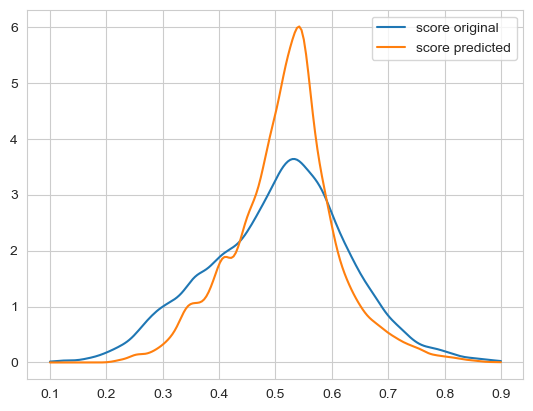

In [179]:
density1 = gaussian_kde((data_cov[data_cov['year'] == 2019])['score_norm'])
density2 = gaussian_kde((data_cov[data_cov['year'] == 2019])['score_norm_pred'])
xs = np.linspace(0.1,0.9,200)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density1(xs),label = "score original 2019")
plt.plot(xs,density2(xs), label = "score predicted 2019")
plt.legend()

#plt.hist(data_cov['score_norm'],density = True ,label = "score original")
#plt.hist(data_cov['score_norm_pred'],density = True , label = "score predicted")
#plt.legend()
plt.show()

## The predicted curve is more skewed towards 0.5 and right, 
## which shows that higher score is predicted for year 2021 and 2019 as comapred 
## to the real score.      

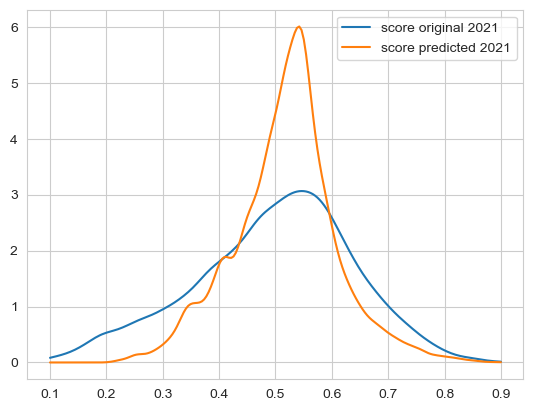

In [180]:
density1 = gaussian_kde((data_cov[data_cov['year'] == 2021])['score_norm'])
density2 = gaussian_kde((data_cov[data_cov['year'] == 2021])['score_norm_pred'])
xs = np.linspace(0.1,0.9,200)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density1(xs),label = "score original 2021")
plt.plot(xs,density2(xs), label = "score predicted 2021")
plt.legend()

#plt.hist(data_cov['score_norm'],density = True ,label = "score original")
#plt.hist(data_cov['score_norm_pred'],density = True , label = "score predicted")
#plt.legend()
plt.show()

## The predicted curve is more skewed towards 0.5 and right, 
## which shows that higher score is predicted for year 2021 and 2019 as comapred 
## to the real score. The real scores have more area being allocated in the lower range of 0.1 to 0.5

In [183]:
data_cov.columns

Index(['year', 'grade_3', 'grade_4', 'grade_5', 'grade_6', 'grade_7',
       'grade_8', 'grade_9', 'exam_english', 'exam_maths', 'state_colorado',
       'state_connecticut', 'state_newyork', 'ziplocation', 'unemp_rate',
       'pop_estimate_norm', 'poverty_all_ages_perc', 'poverty_0_17_perc',
       'poverty_rel_children_5_17_perc', 'hybrid_perc', 'inperson_perc',
       'virtual_perc', 'closed_perc', 'median_income_norm',
       'NewCasesCombined_norm', 'score_norm', 'score_norm_pred',
       'percentage_change'],
      dtype='object')

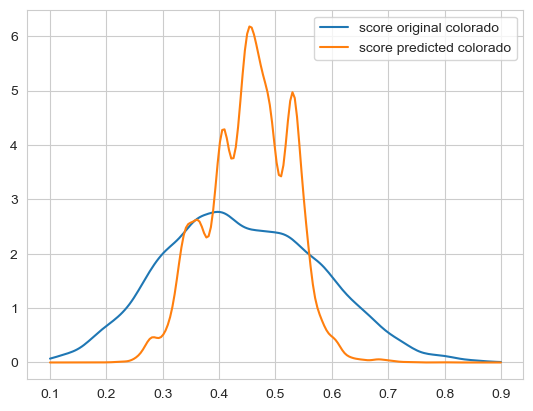

In [187]:
density1 = gaussian_kde((data_cov[data_cov['state_colorado'] == 1])['score_norm'])
density2 = gaussian_kde((data_cov[data_cov['state_colorado'] == 1])['score_norm_pred'])
xs = np.linspace(0.1,0.9,200)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density1(xs),label = "score original colorado")
plt.plot(xs,density2(xs), label = "score predicted colorado")
plt.legend()

#plt.hist(data_cov['score_norm'],density = True ,label = "score original")
#plt.hist(data_cov['score_norm_pred'],density = True , label = "score predicted")
#plt.legend()
plt.show()

## there is huge difference seen with respected to predicted score and actual scores in state of colorado. The original scores are
## spread from lower range of 0.1, where as predicted ones start from 0.3 and have major density located around 0.3 till 0.6.


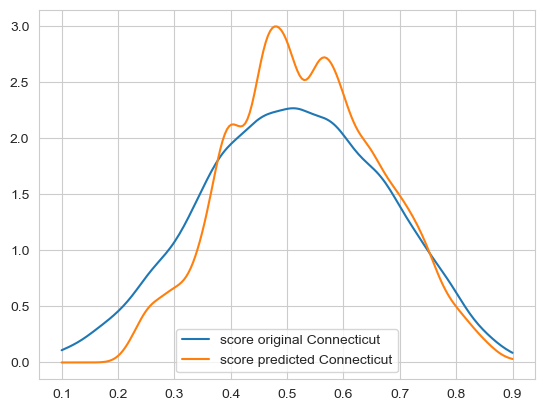

In [188]:
density1 = gaussian_kde((data_cov[data_cov['state_connecticut'] == 1])['score_norm'])
density2 = gaussian_kde((data_cov[data_cov['state_connecticut'] == 1])['score_norm_pred'])
xs = np.linspace(0.1,0.9,200)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density1(xs),label = "score original Connecticut")
plt.plot(xs,density2(xs), label = "score predicted Connecticut")
plt.legend()

#plt.hist(data_cov['score_norm'],density = True ,label = "score original")
#plt.hist(data_cov['score_norm_pred'],density = True , label = "score predicted")
#plt.legend()
plt.show()

## Same trend is seen for state Connecticut, however, the trend is not as dissimilar of predicted vs. original as seens in the case of 
## of colorado. 

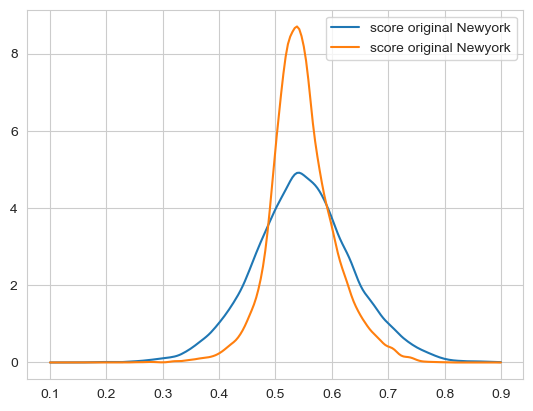

In [189]:
density1 = gaussian_kde((data_cov[data_cov['state_newyork'] == 1])['score_norm'])
density2 = gaussian_kde((data_cov[data_cov['state_newyork'] == 1])['score_norm_pred'])
xs = np.linspace(0.1,0.9,200)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density1(xs),label = "score original Newyork")
plt.plot(xs,density2(xs), label = "score original Newyork")
plt.legend()

#plt.hist(data_cov['score_norm'],density = True ,label = "score original")
#plt.hist(data_cov['score_norm_pred'],density = True , label = "score predicted")
#plt.legend()
plt.show()

## The predicted curve is more skewed towards 0.5 and right, 
## which shows that higher score is predicted for year 2021 and 2019 as comapred 
## to the real score. The real scores have more area being allocated in the lower range of 0.1 to 0.5

C:\Users\ameen\AppData\Local\Temp\ipykernel_28344\2840702371.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cov['percentage_change'] = (data_cov['score_norm_pred'] - data_cov['score_norm'])


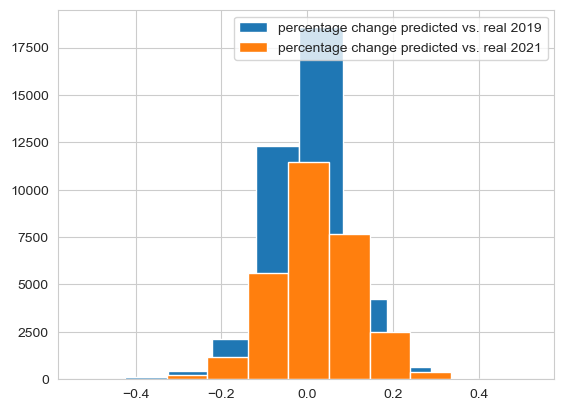

In [170]:
data_cov['percentage_change'] = (data_cov['score_norm_pred'] - data_cov['score_norm']) 
plt.hist((data_cov[data_cov['year'] == 2019])['percentage_change'] ,label = "percentage change predicted vs. real 2019")
plt.hist((data_cov[data_cov['year'] == 2021])['percentage_change'] ,label = "percentage change predicted vs. real 2021")
plt.legend()
plt.show()

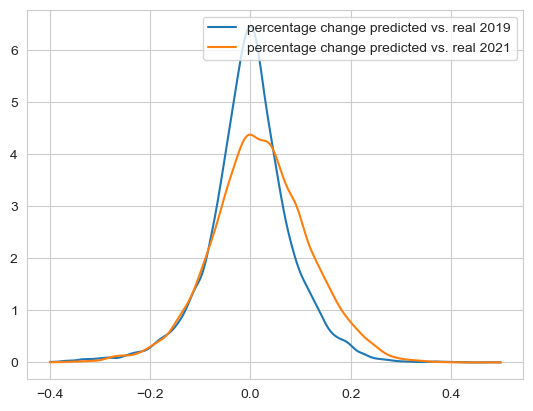

In [174]:
density1 = gaussian_kde((data_cov[data_cov['year'] == 2019])['percentage_change'])
density2 = gaussian_kde((data_cov[data_cov['year'] == 2021])['percentage_change'])
xs = np.linspace(-0.4,0.5,200)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density1(xs),label = 'percentage change predicted vs. real 2019')
plt.plot(xs,density2(xs), label = 'percentage change predicted vs. real 2021')
plt.legend()
plt.show()